Assumed dependencies: m0 * h, (h-d)/radwidth, h/(h-d), (h-d1)/(h-d2).

Two steps:
1. Fix these, generate a lot of data, see how the histograms look (seek hints at other dependencies).
2. Fix three and vary 1 (m0h, h-d/radwidth), or fix two and vary two (the two height ratios) to see what happens and what dependencies might be.

In [ ]:
import sys
import os
sys.path.append(os.path.relpath('../../../'))
sys.path.append(os.path.relpath('../../'))

from helpers import *
import numpy as np
from numpy import random

import matplotlib.pyplot as plt

In [2]:
def populate_hist_vals(m0h, hmdr, left_ratio, right_ratio):
  hmd2 = random.uniform(low = 1., high = 50.)
  hmd1 = left_ratio * hmd2
  h = right_ratio * hmd2
  m0 = m0h/h
  radwidth2 = hmd2/hmdr
  hmd0 = random.uniform(low = 0., high = h)
  radwidth0 = hmd0/random.uniform(low = 1., high = 3.)
  radwidth1 = hmd1/random.uniform(low = 1., high = 3.)
  hmds = [hmd0, hmd1, hmd2]
  radwidths = [radwidth0, radwidth1, radwidth2]
  d = [h - hmds[i] for i in range(3)]
  a = [sum(radwidths[:i + 1]) for i in range(3)]
  return h, d, a, m0

def swap_vals(prob, d, a):
  # Avoids mk recomputations.
  prob.d = d
  prob.a = a
  prob.scale = a
  return prob

In [3]:
file1 = "histogram_data.pkl"

hist_m0hs = [10, 40]
hist_hmdrs = [2, 20]
hist_lratios = [0.4, 0.99, 1.3]
hist_rratios = [1.4, 2, 6]

quads = [(m0h, hmdr, lratio, rratio) for m0h in hist_m0hs for hmdr in hist_hmdrs
          for lratio in hist_lratios for rratio in hist_rratios]

big_nmk = 200
nmk_max = 150
NMK = [big_nmk] * 4
heaving = [0, 0, 1]
rho = 1023

# fixed_prob_lsts = []

# for quad in quads:
#   fixed_prob_lst = []
#   for j in range(50):
#     h, d, a, m0 =  populate_hist_vals(quad[0], quad[1], quad[2], quad[3])
#     prob = ConvergenceProblemI(h, d, a, heaving, NMK, m0, rho)
#     mk = prob.m_k
#     info = {"h" : h,
#             "d" : d,
#             "a" : a,
#             "region" : 2,
#             "m0s" : [m0]}
#     print(j, info)
#     data_dict = merge_dicts(info, prob.convergence_study_over_m0s(nmk_max, [m0], [mk]))
#     fixed_prob_lst.append(data_dict)
#   fixed_prob_lsts.append(fixed_prob_lst)
#   update_data_file(fixed_prob_lsts, file1)
#   print("Finished a quad.")

In [4]:
fixed_prob_lsts = open_pkl_file(file1)
for fixed_prob_lst in fixed_prob_lsts:
  generate_convergence_data(fixed_prob_lst, [0.01, 0.005])
  # Ignoring log data for now.
  # log_data = generate_log_data(fixed_prob_lst)

In [5]:
def histogram(data, hydro, error, ylab = "count", title = "convergence"):
  vals = [data_dict[data_dict["m0s"][0]][f"convergence point {error:.2g} " + hydro] for data_dict in data]
  if min(vals) == max(vals):
    bins = [vals[0] - 0.5, vals[0] + 0.5]
  else:
    bins = np.arange(min(vals)-0.5, max(vals)+1.5, 1)
  plt.hist(vals, bins = bins, edgecolor = "black")
  plt.xlabel(f"convergence point {error:.2g} " + hydro)
  plt.ylabel(ylab)
  plt.title(hydro + " " + title)
  plt.show()
  return vals

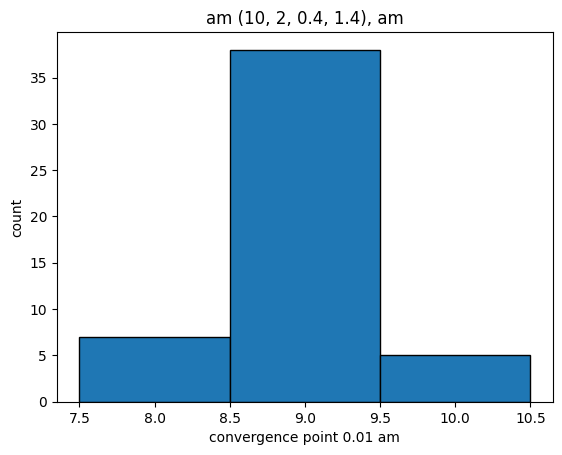

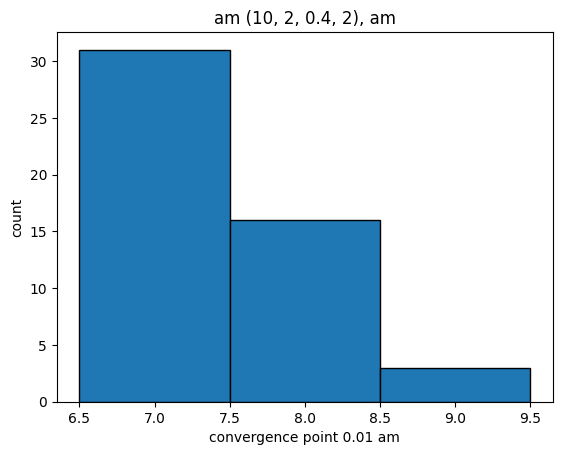

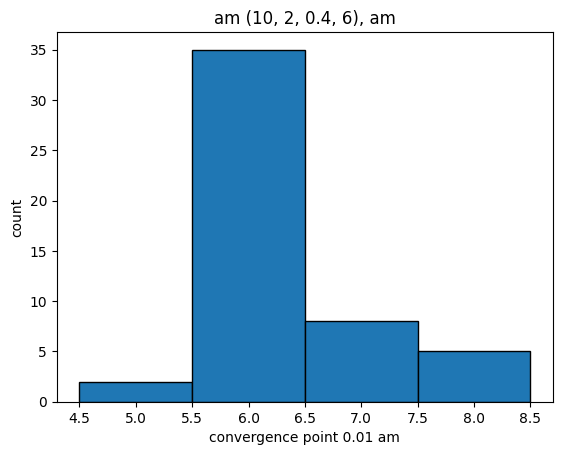

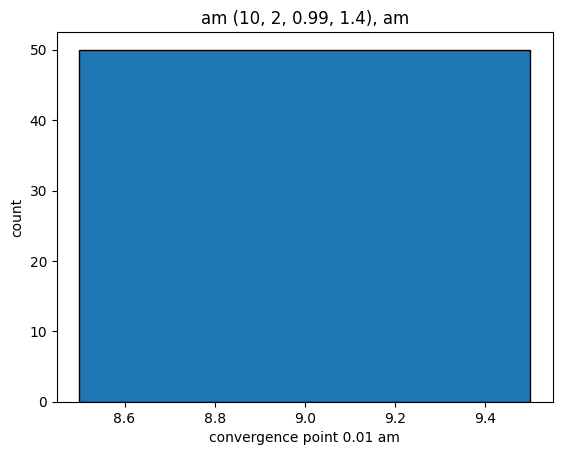

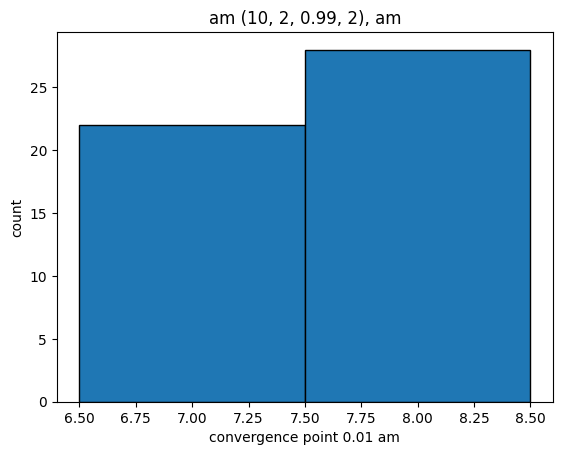

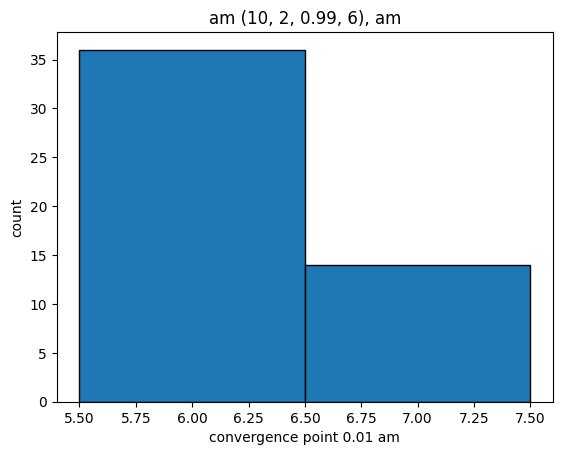

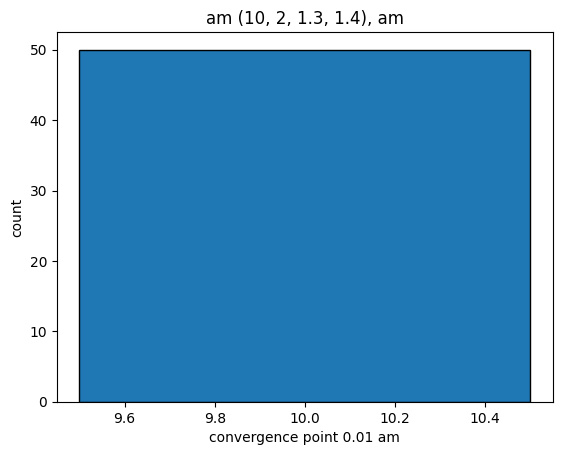

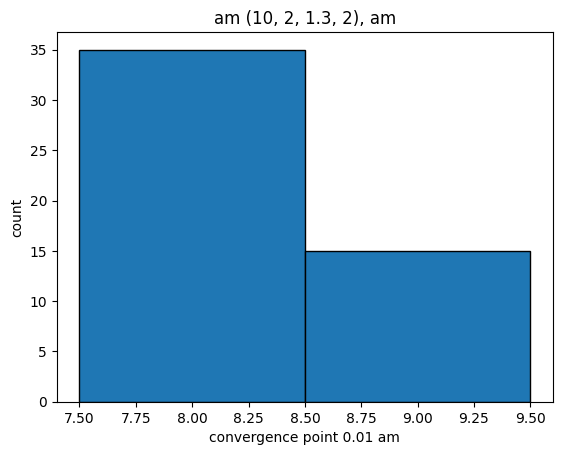

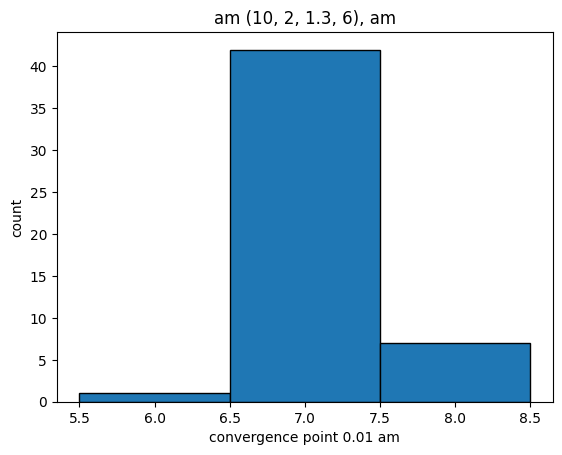

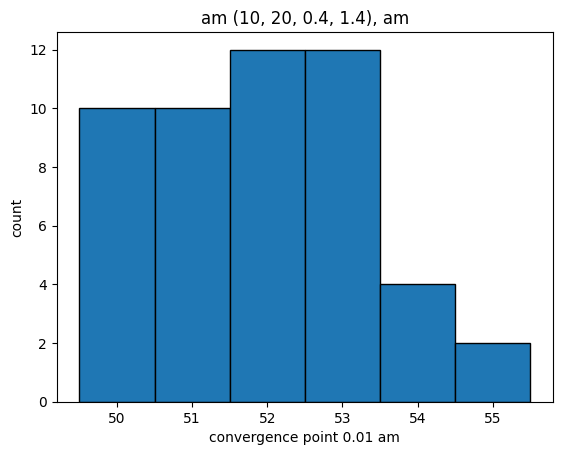

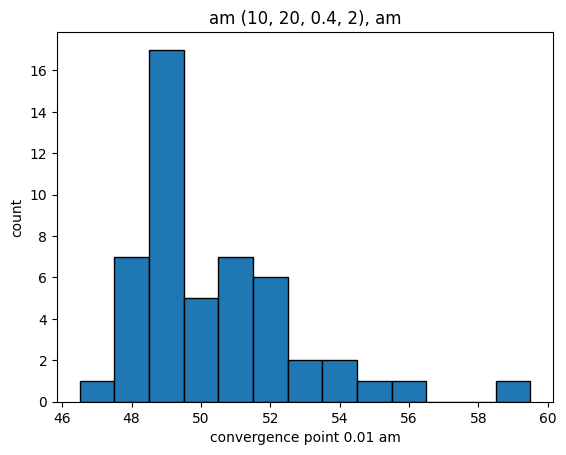

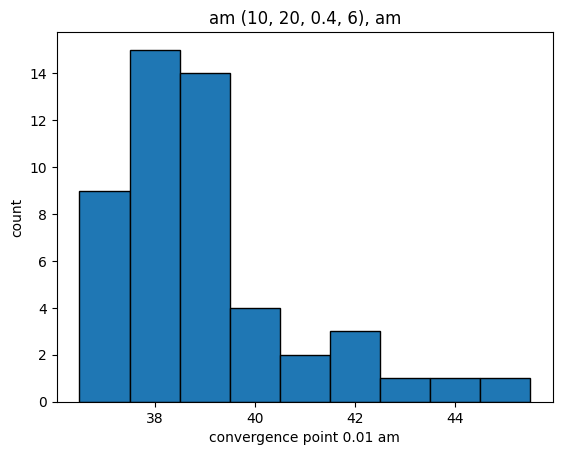

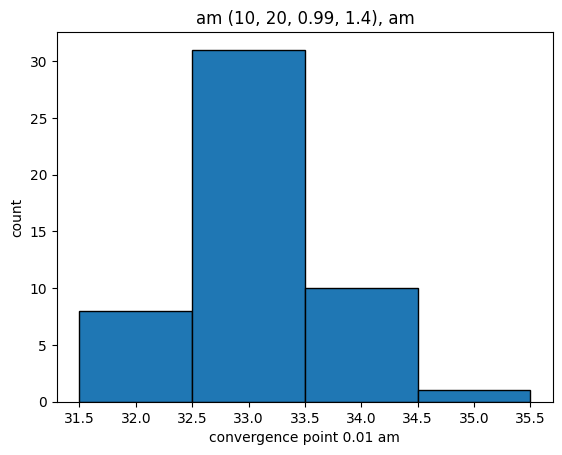

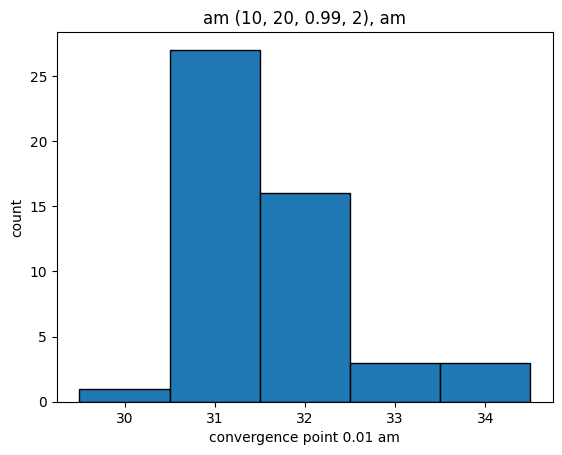

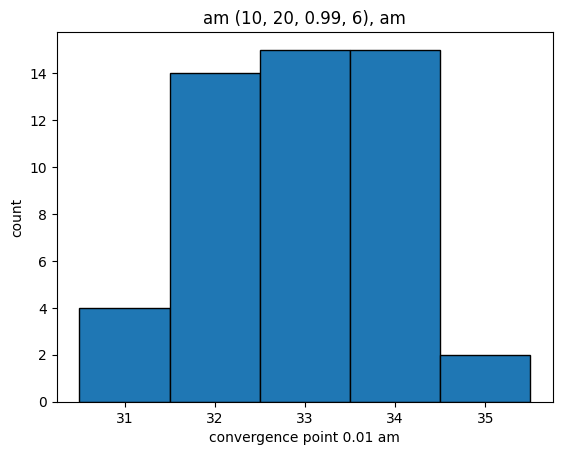

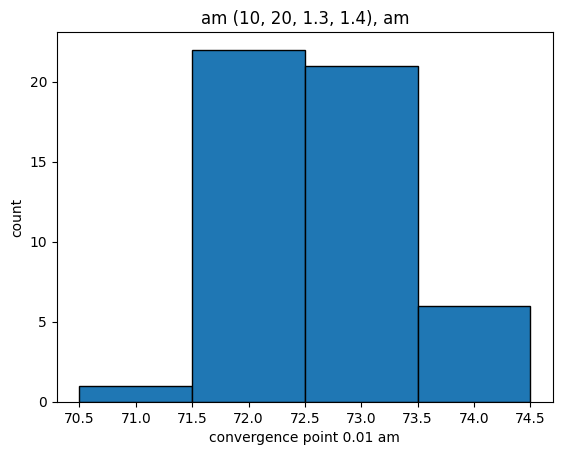

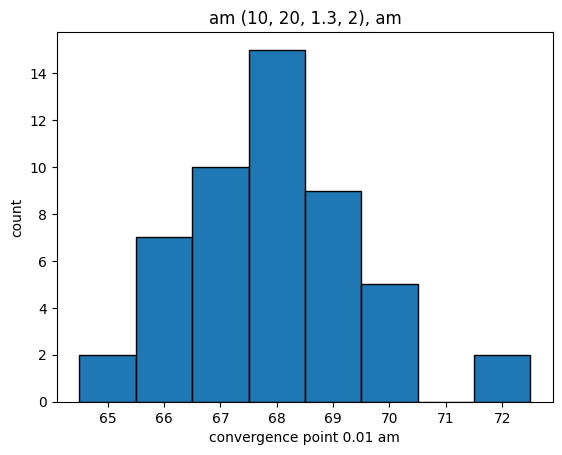

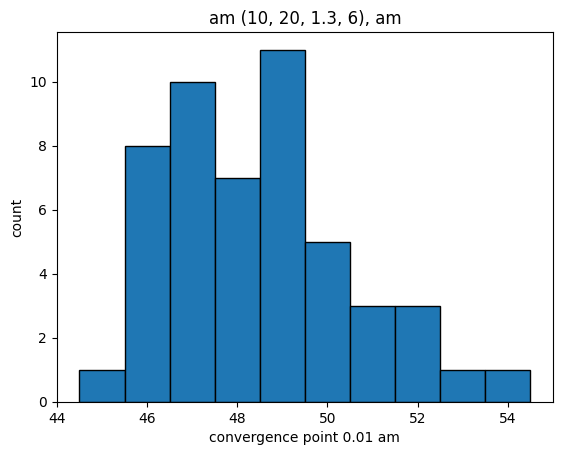

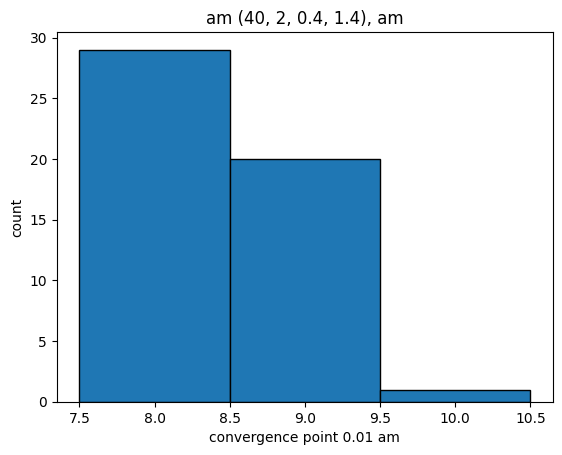

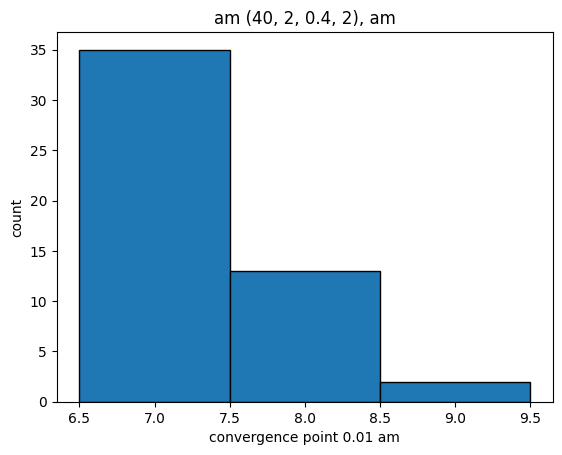

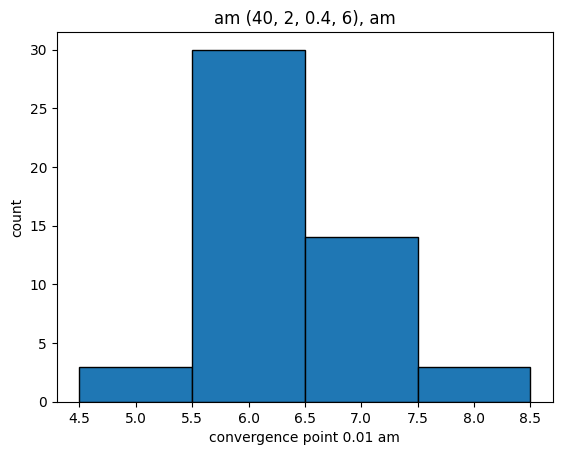

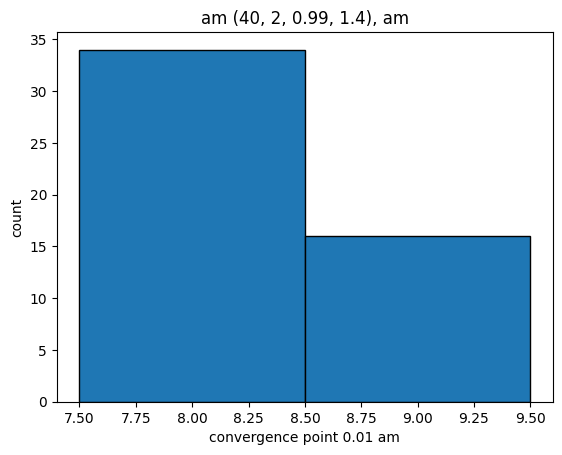

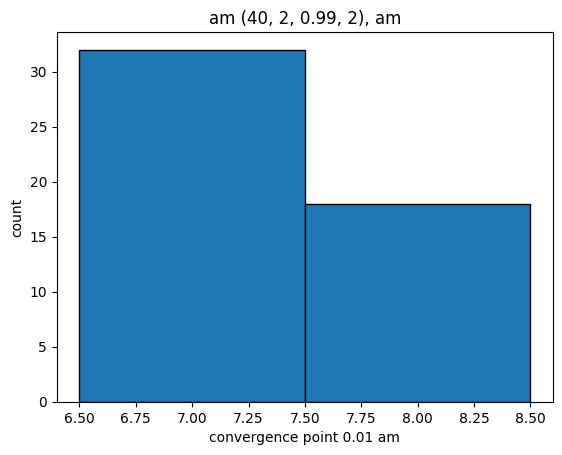

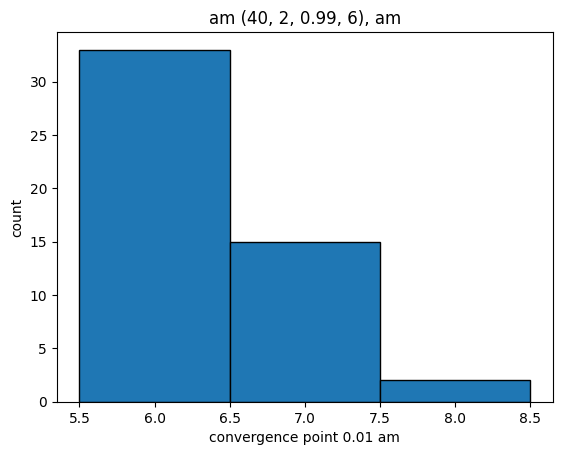

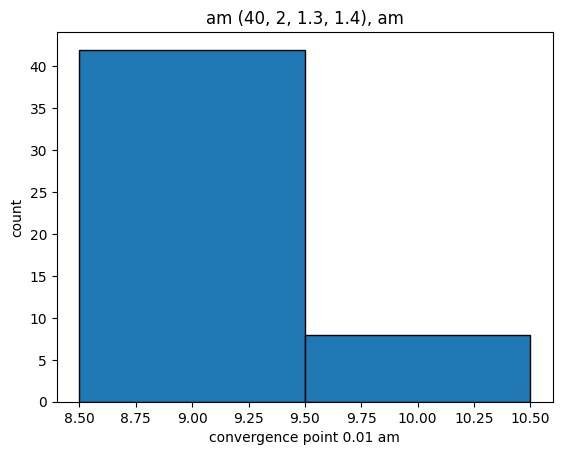

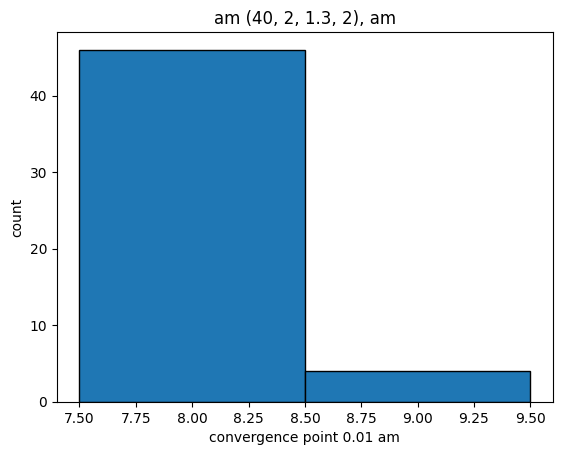

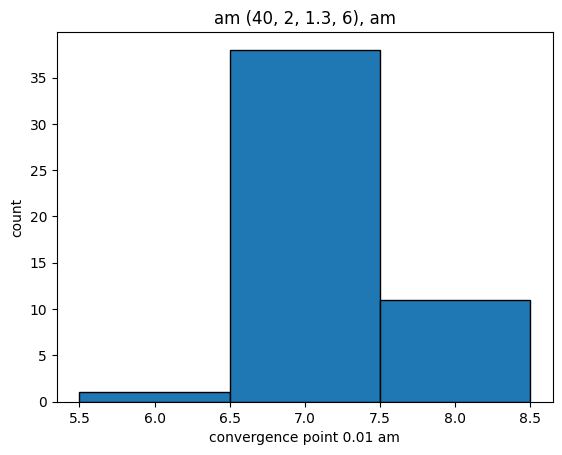

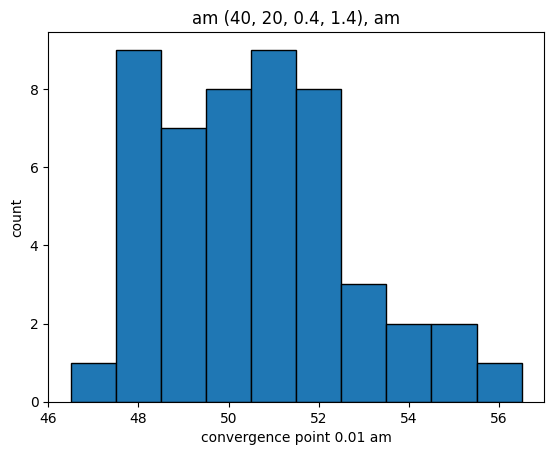

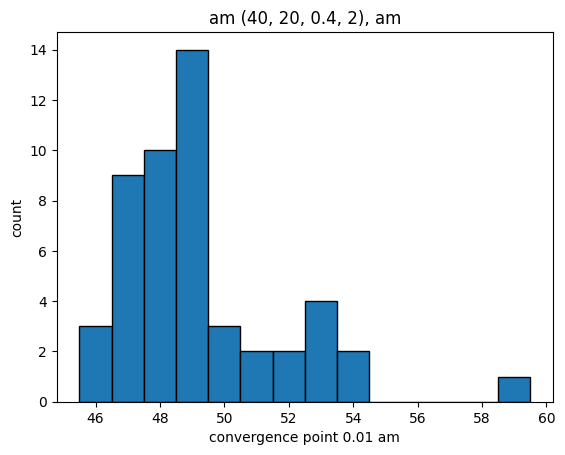

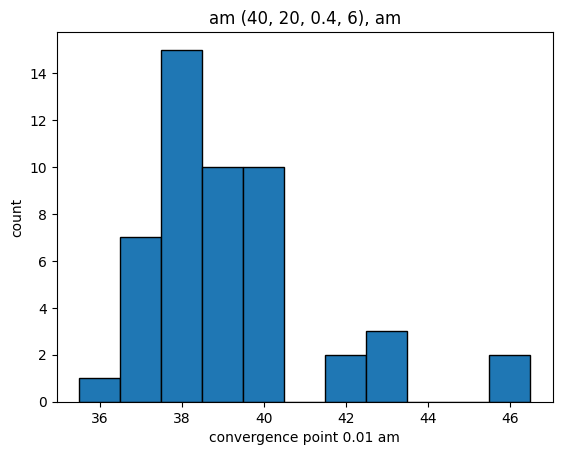

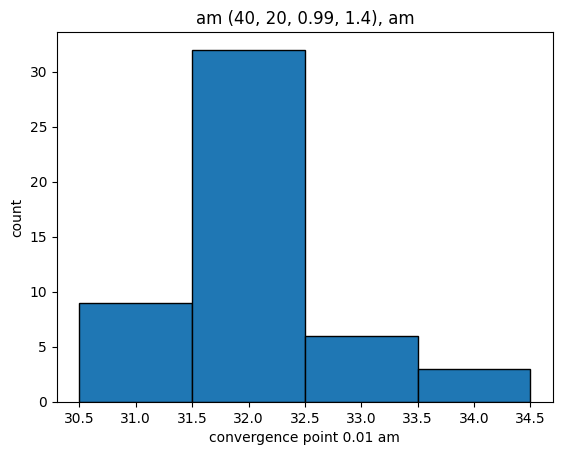

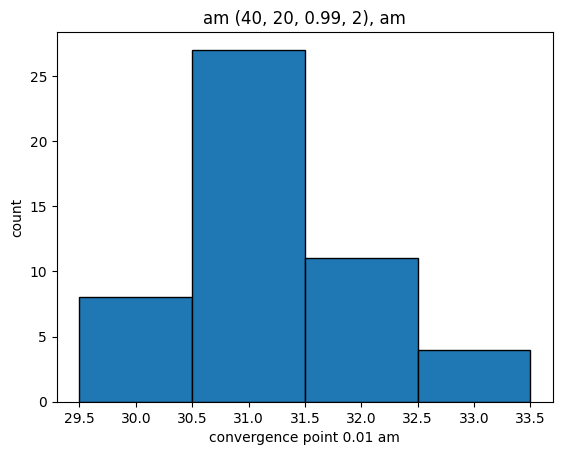

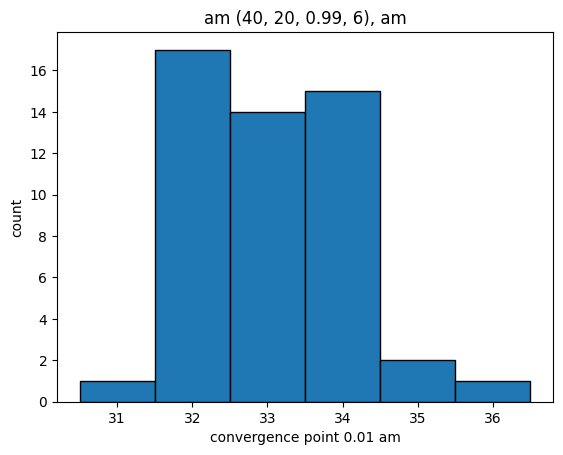

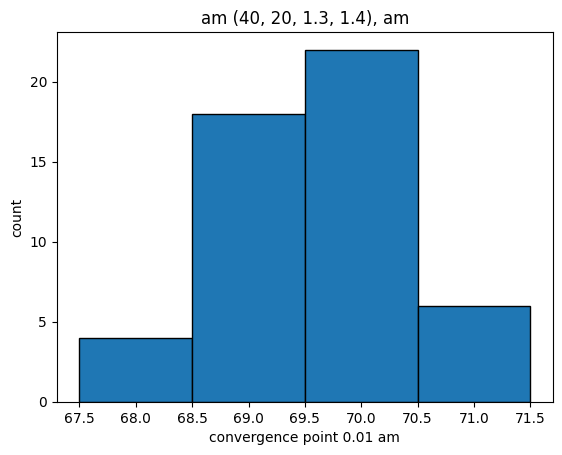

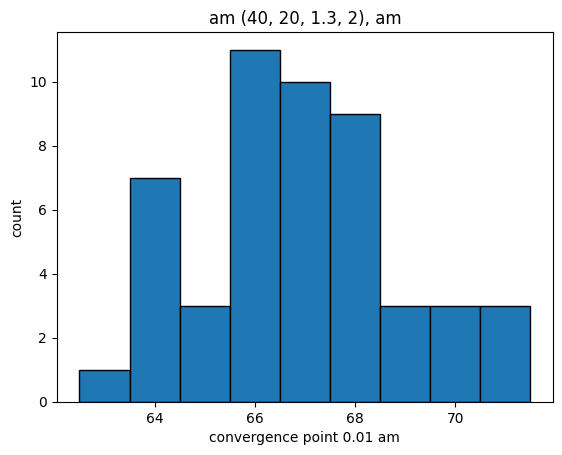

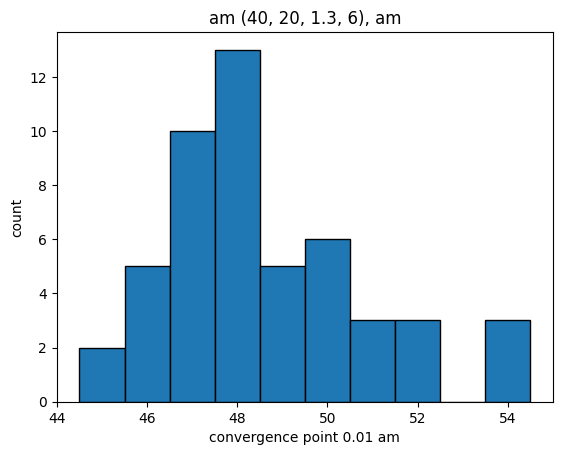

In [9]:
wide_variation_cases = []
for idx, quad in enumerate(quads):
  vals = histogram(fixed_prob_lsts[idx],"am", 0.01, ylab = "count", title = f"{quad}, am")
  if max(vals) - min(vals) > 7:
    wide_variation_cases.append(idx)

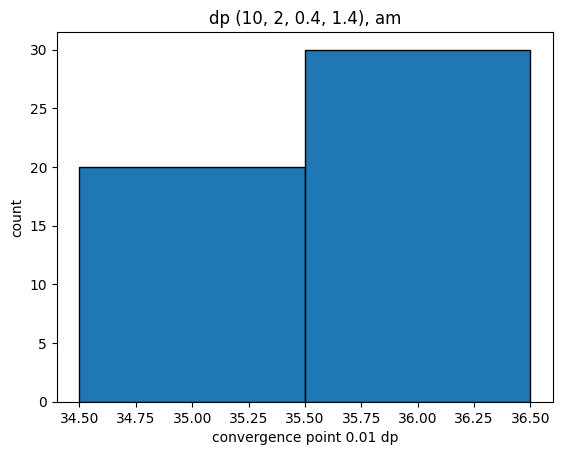

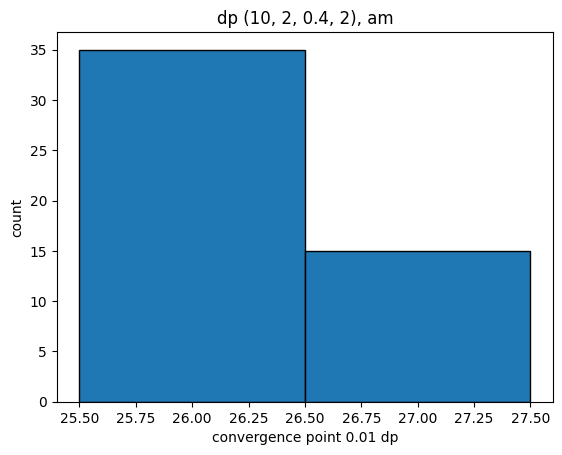

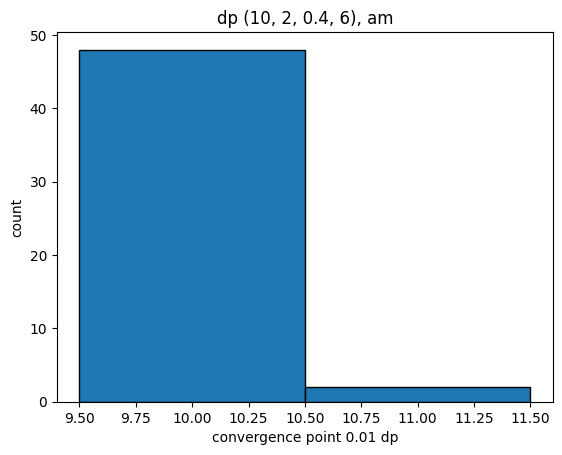

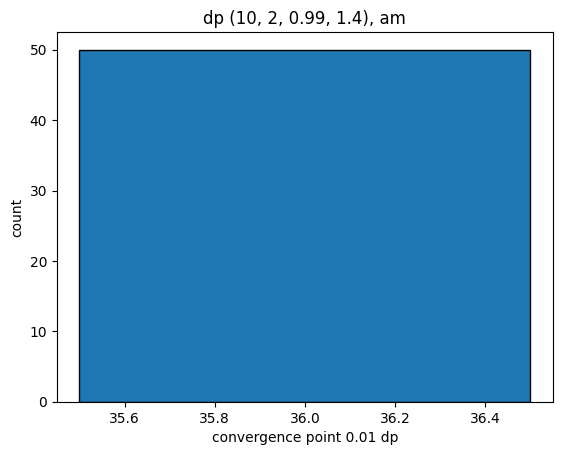

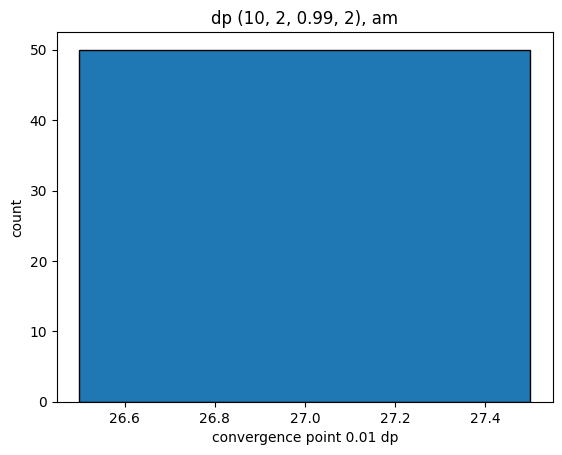

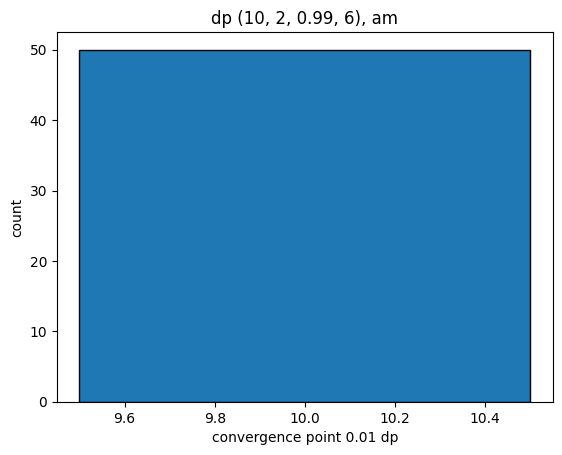

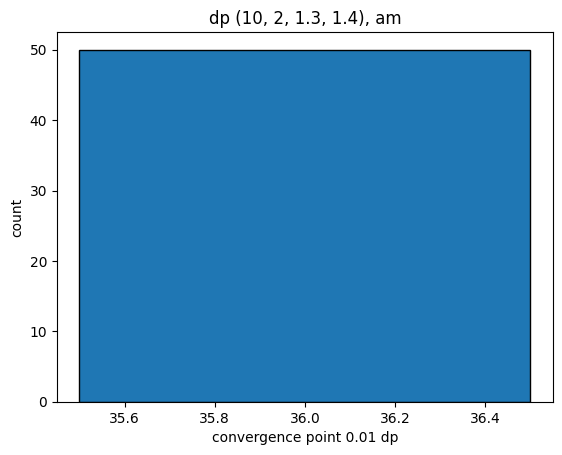

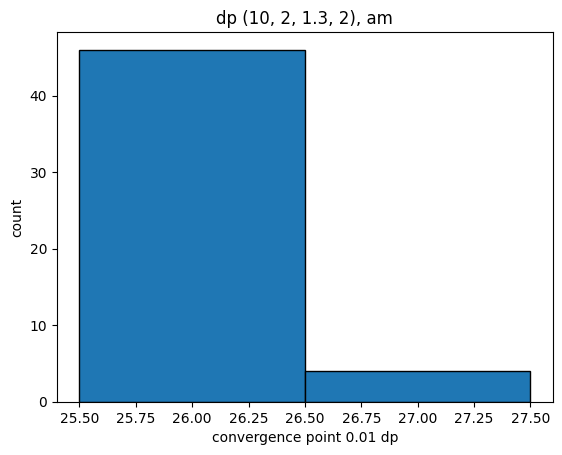

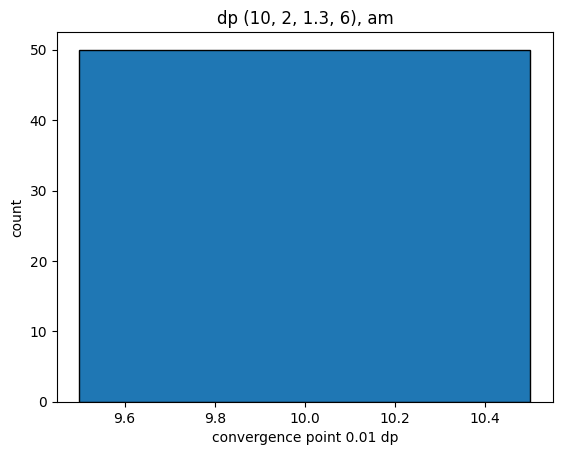

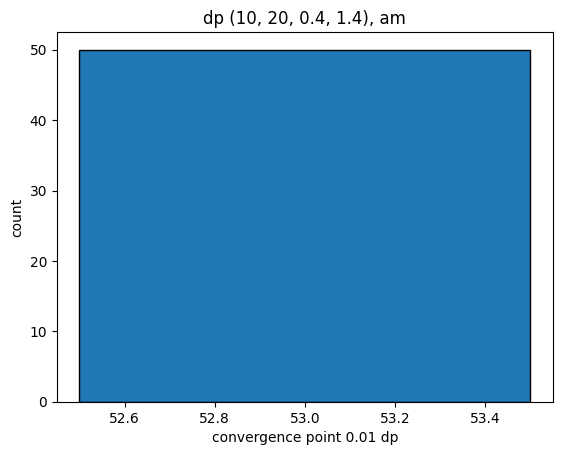

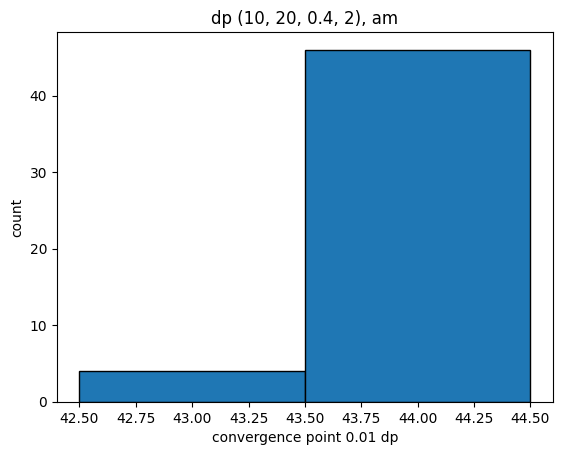

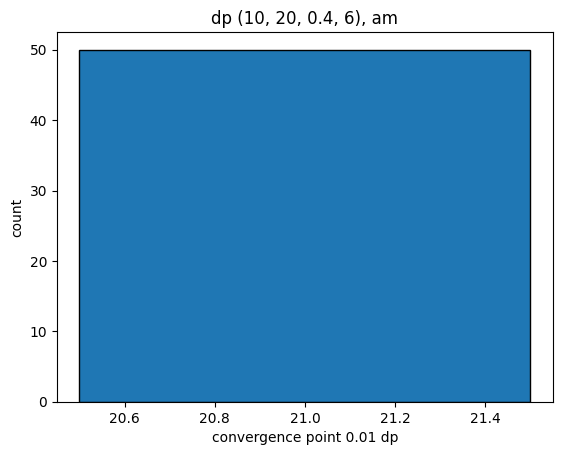

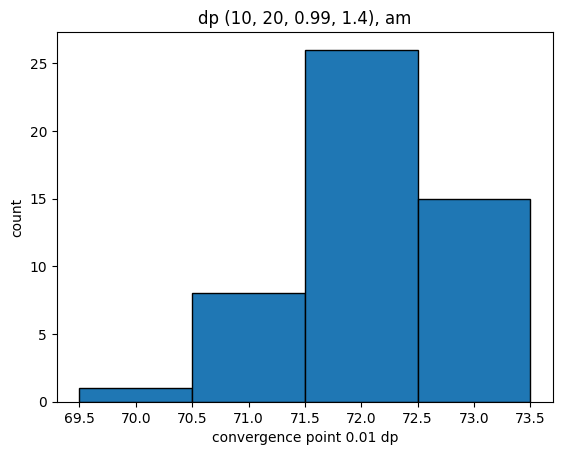

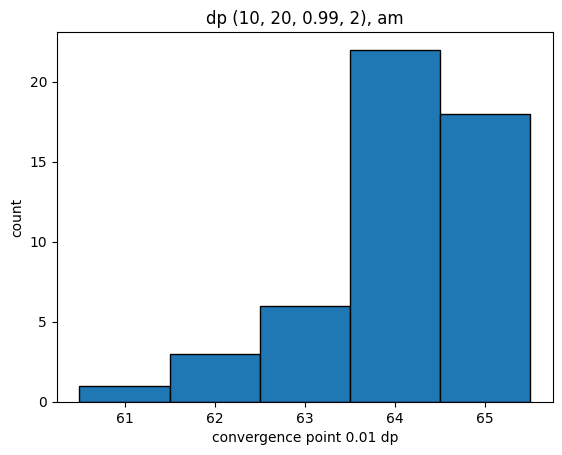

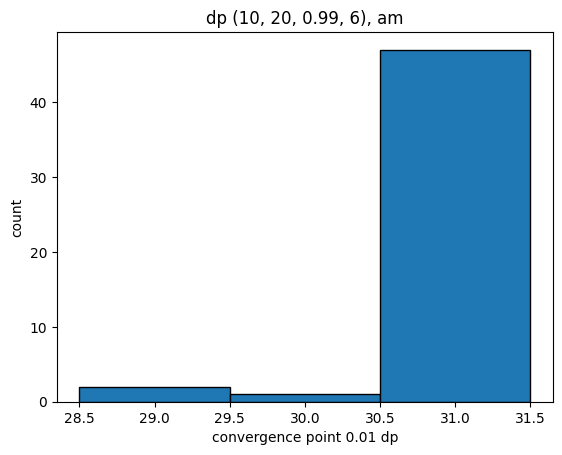

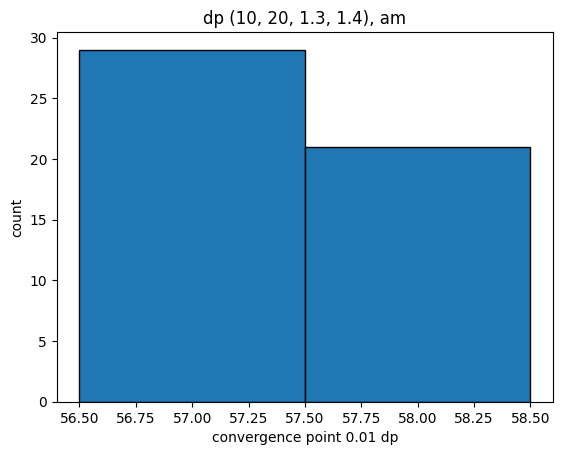

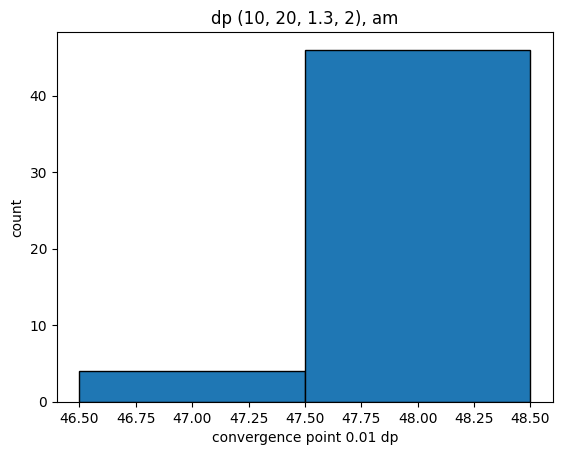

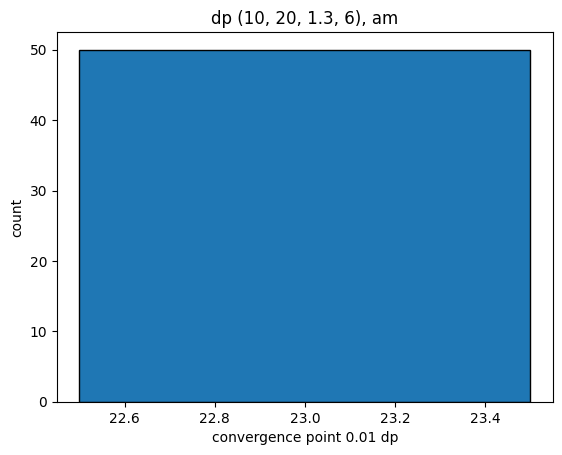

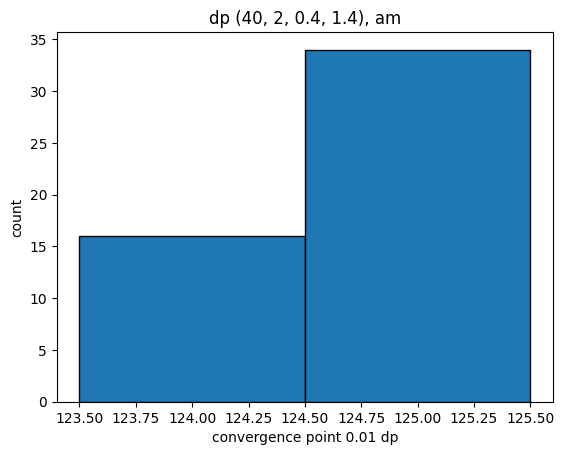

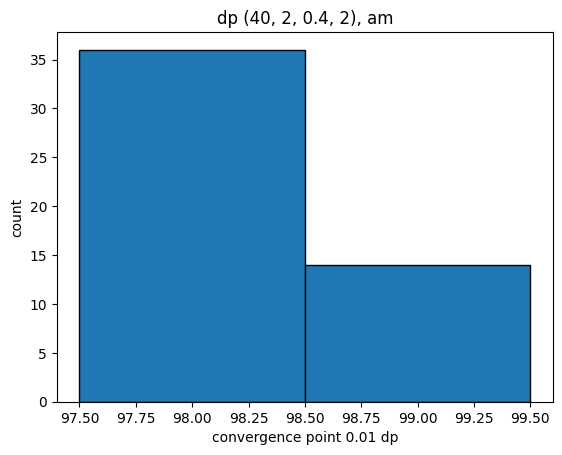

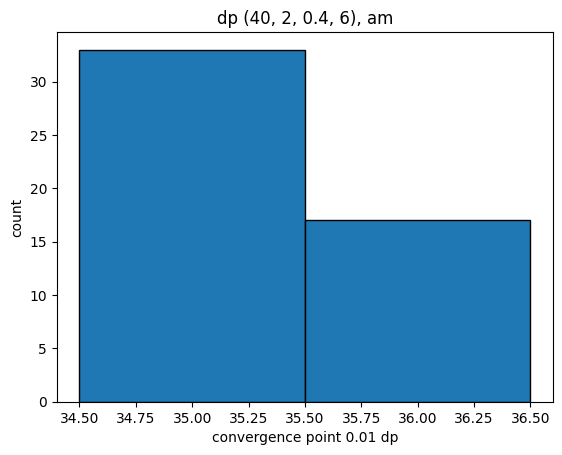

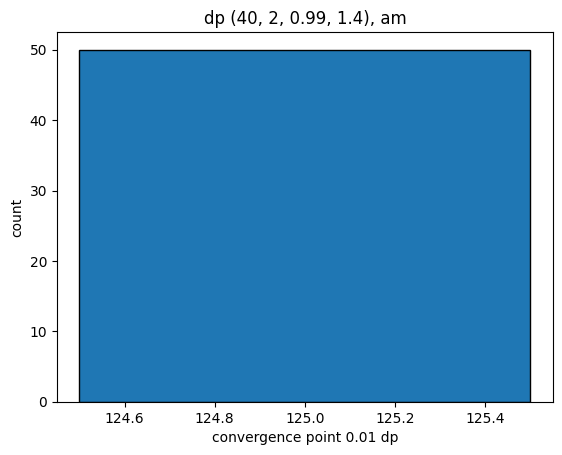

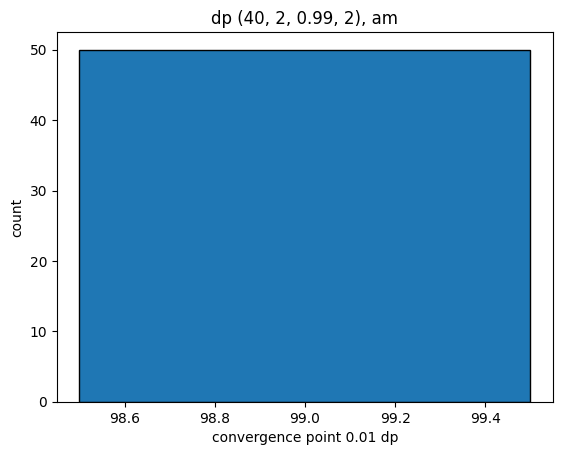

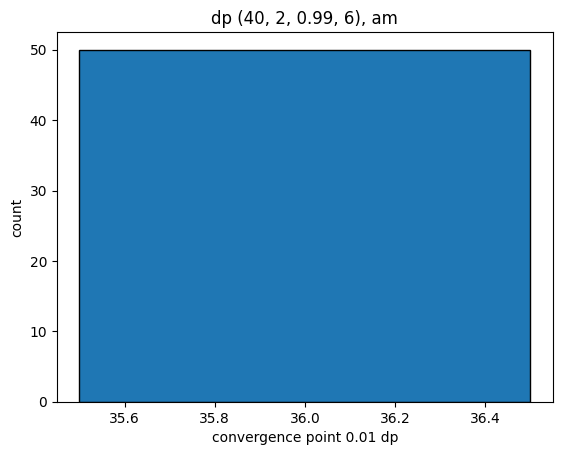

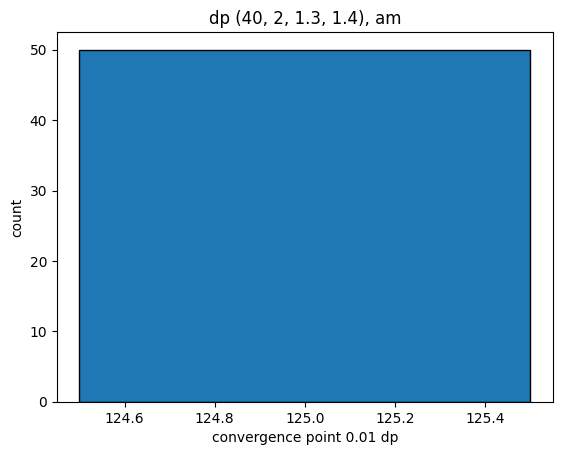

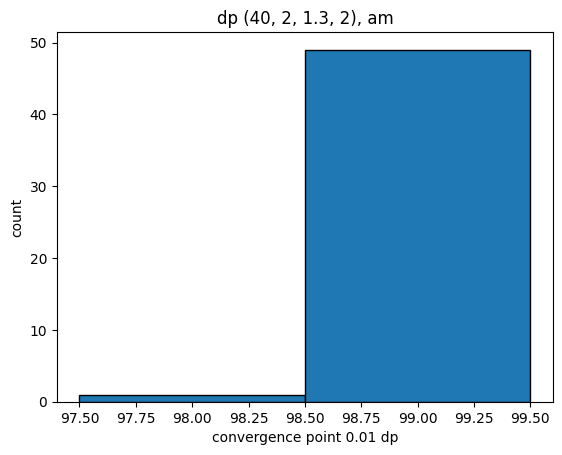

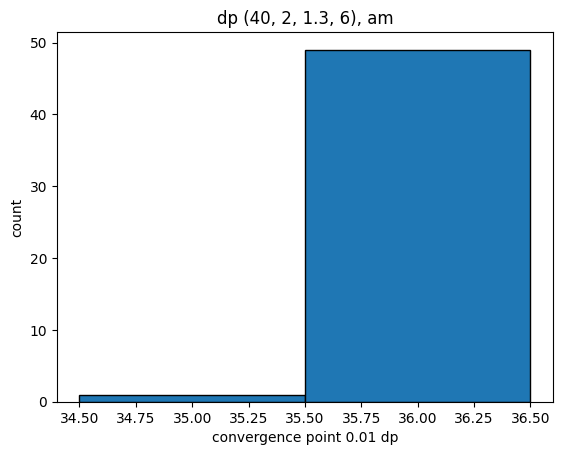

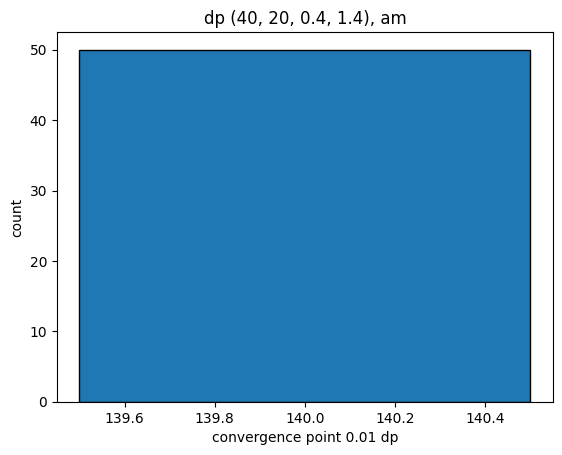

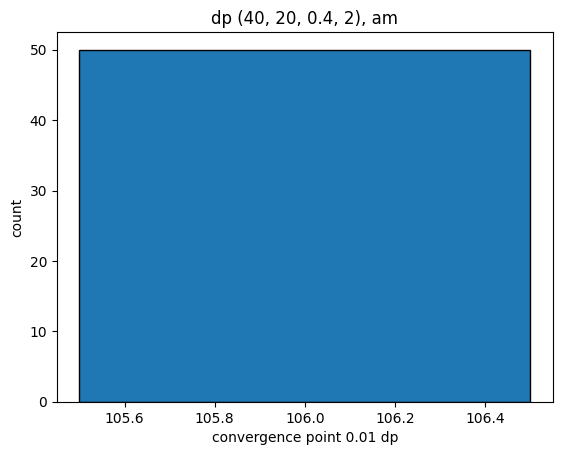

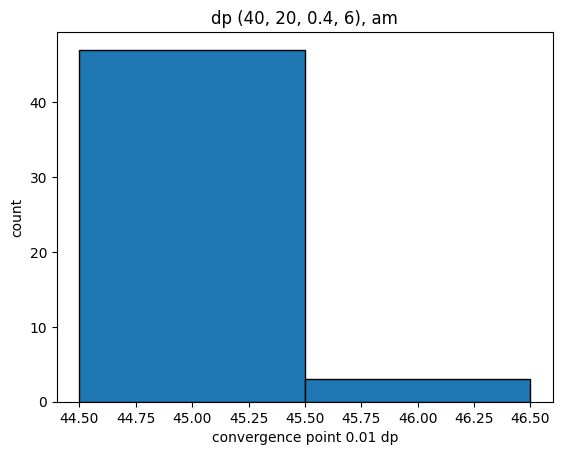

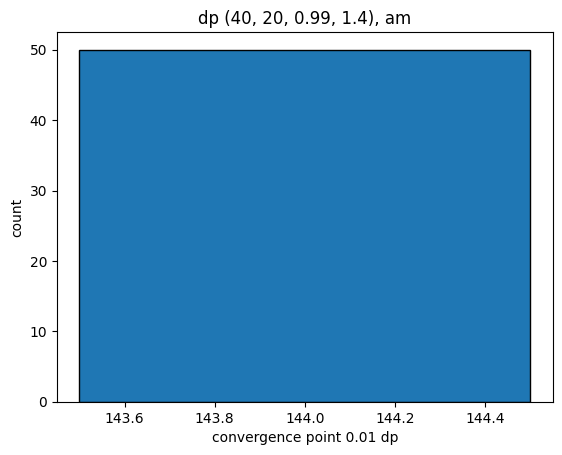

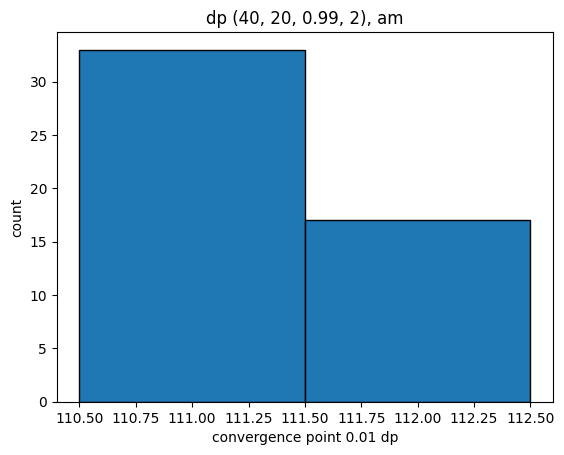

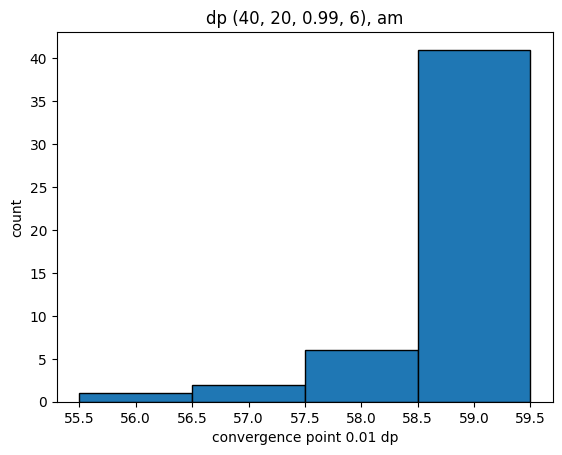

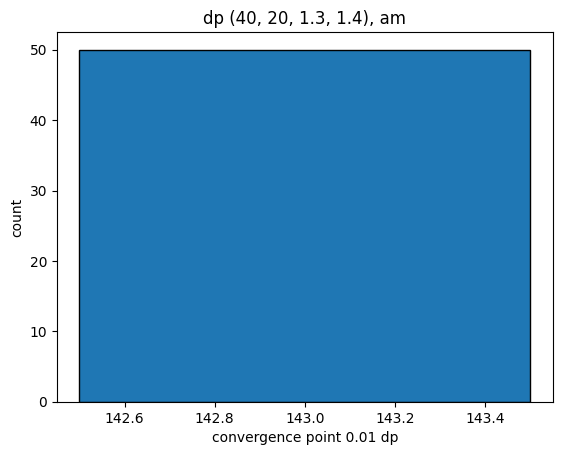

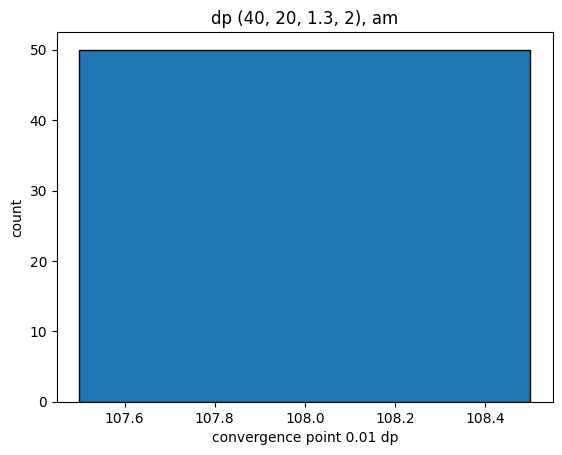

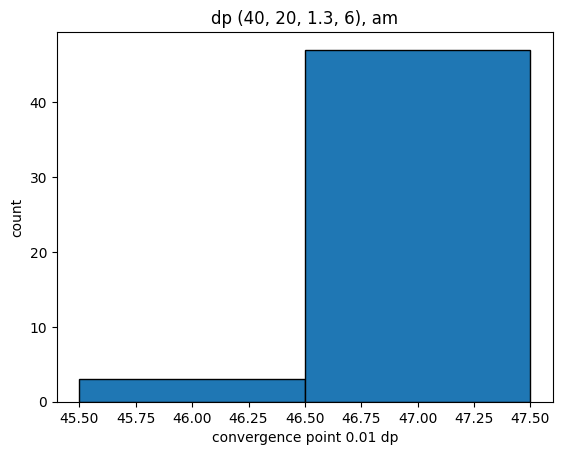

In [7]:
# wide_variation_cases = []
for idx, quad in enumerate(quads):
  vals = histogram(fixed_prob_lsts[idx],"dp", 0.01, ylab = "count", title = f"{quad}, am")
  # if max(vals) - min(vals) > 10:
  #   wide_variation_cases.append(idx)

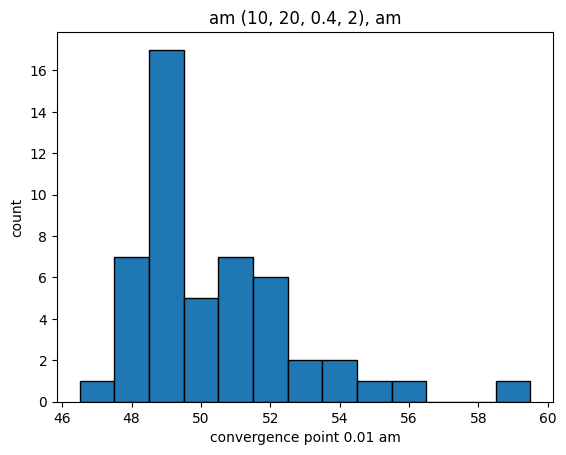

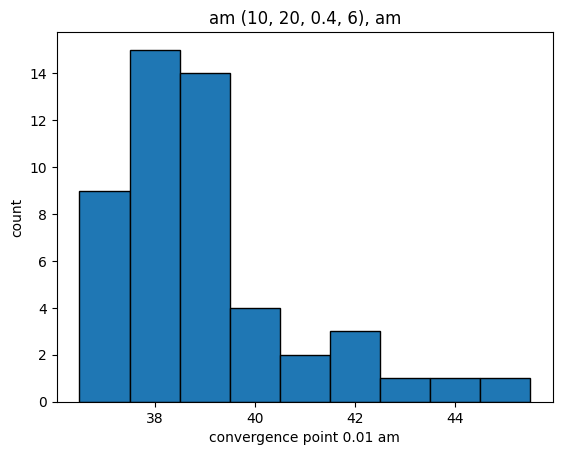

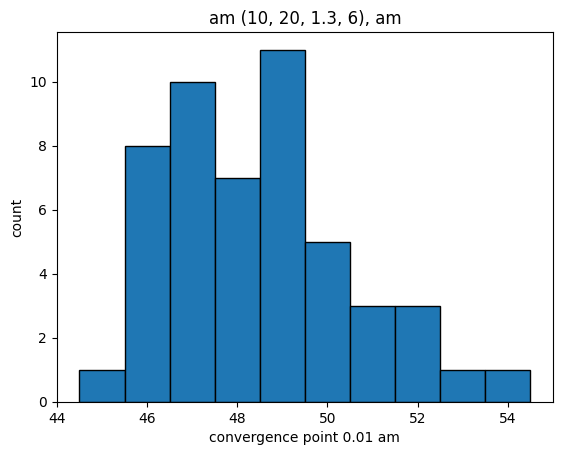

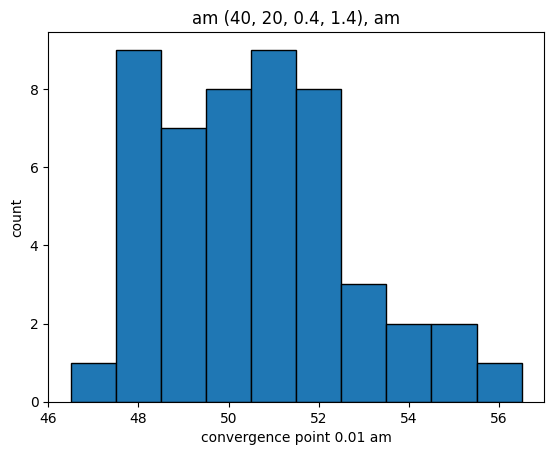

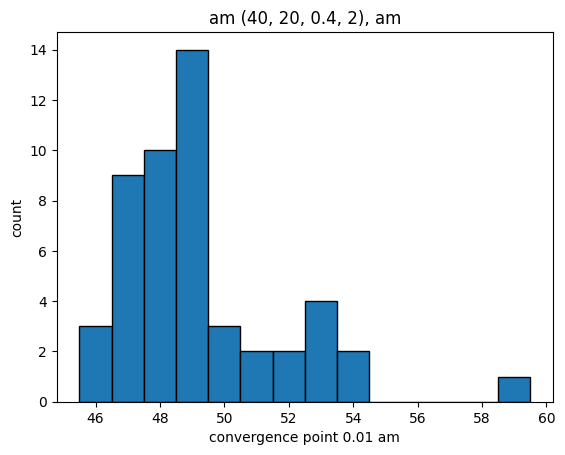

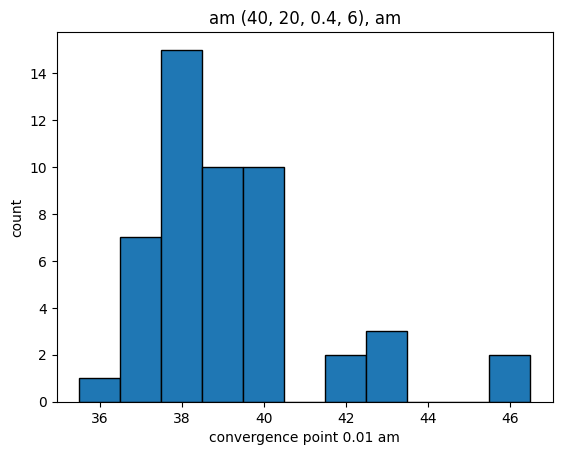

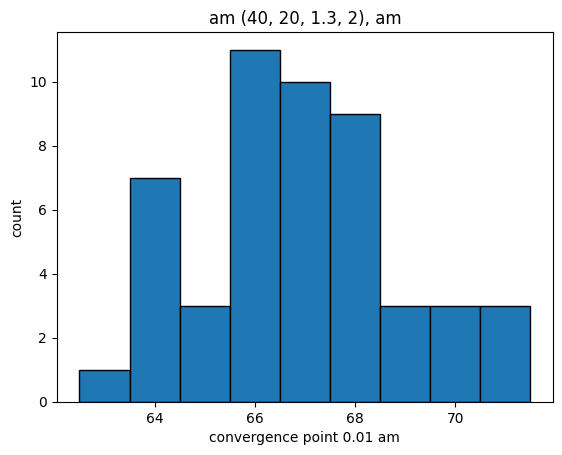

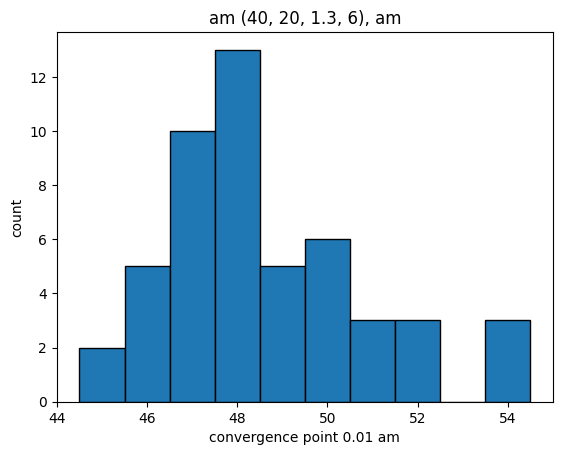

In [10]:
for idx, quad in enumerate(quads):
  if idx in wide_variation_cases:
    histogram(fixed_prob_lsts[idx],"am", 0.01, ylab = "count", title = f"{quad}, am")

In [23]:
def plot_varied_cases(fixed_prob_lsts, idx):
  subset = fixed_prob_lsts[idx].copy()
  val_func = lambda data: data[data["m0s"][0]]["convergence point 0.01 am"]
  subset.sort(key = val_func)
  vals = [val_func(data) for data in subset]
  filter_and_plot_shapes(subset, lambda data_dict, m0 : True, 
                        lambda data_dict, m0 : get_plasma_color(data_dict[m0]["convergence point 0.01 am"], min_value = min(vals), max_value=max(vals)),
                        ppr = 10, figsize_per_plot = (2, 2))
  xs = [(data_dict["a"][2] - data_dict["a"][1])/data_dict["a"][2] for data_dict in subset]
  ys = [data_dict[data_dict["m0s"][0]]["convergence point 0.01 am"] for data_dict in subset]
  plt.plot(xs, ys)
  plt.xlabel("radwidth2/(total body radius)")
  plt.ylabel("convergence point")
  plt.show()

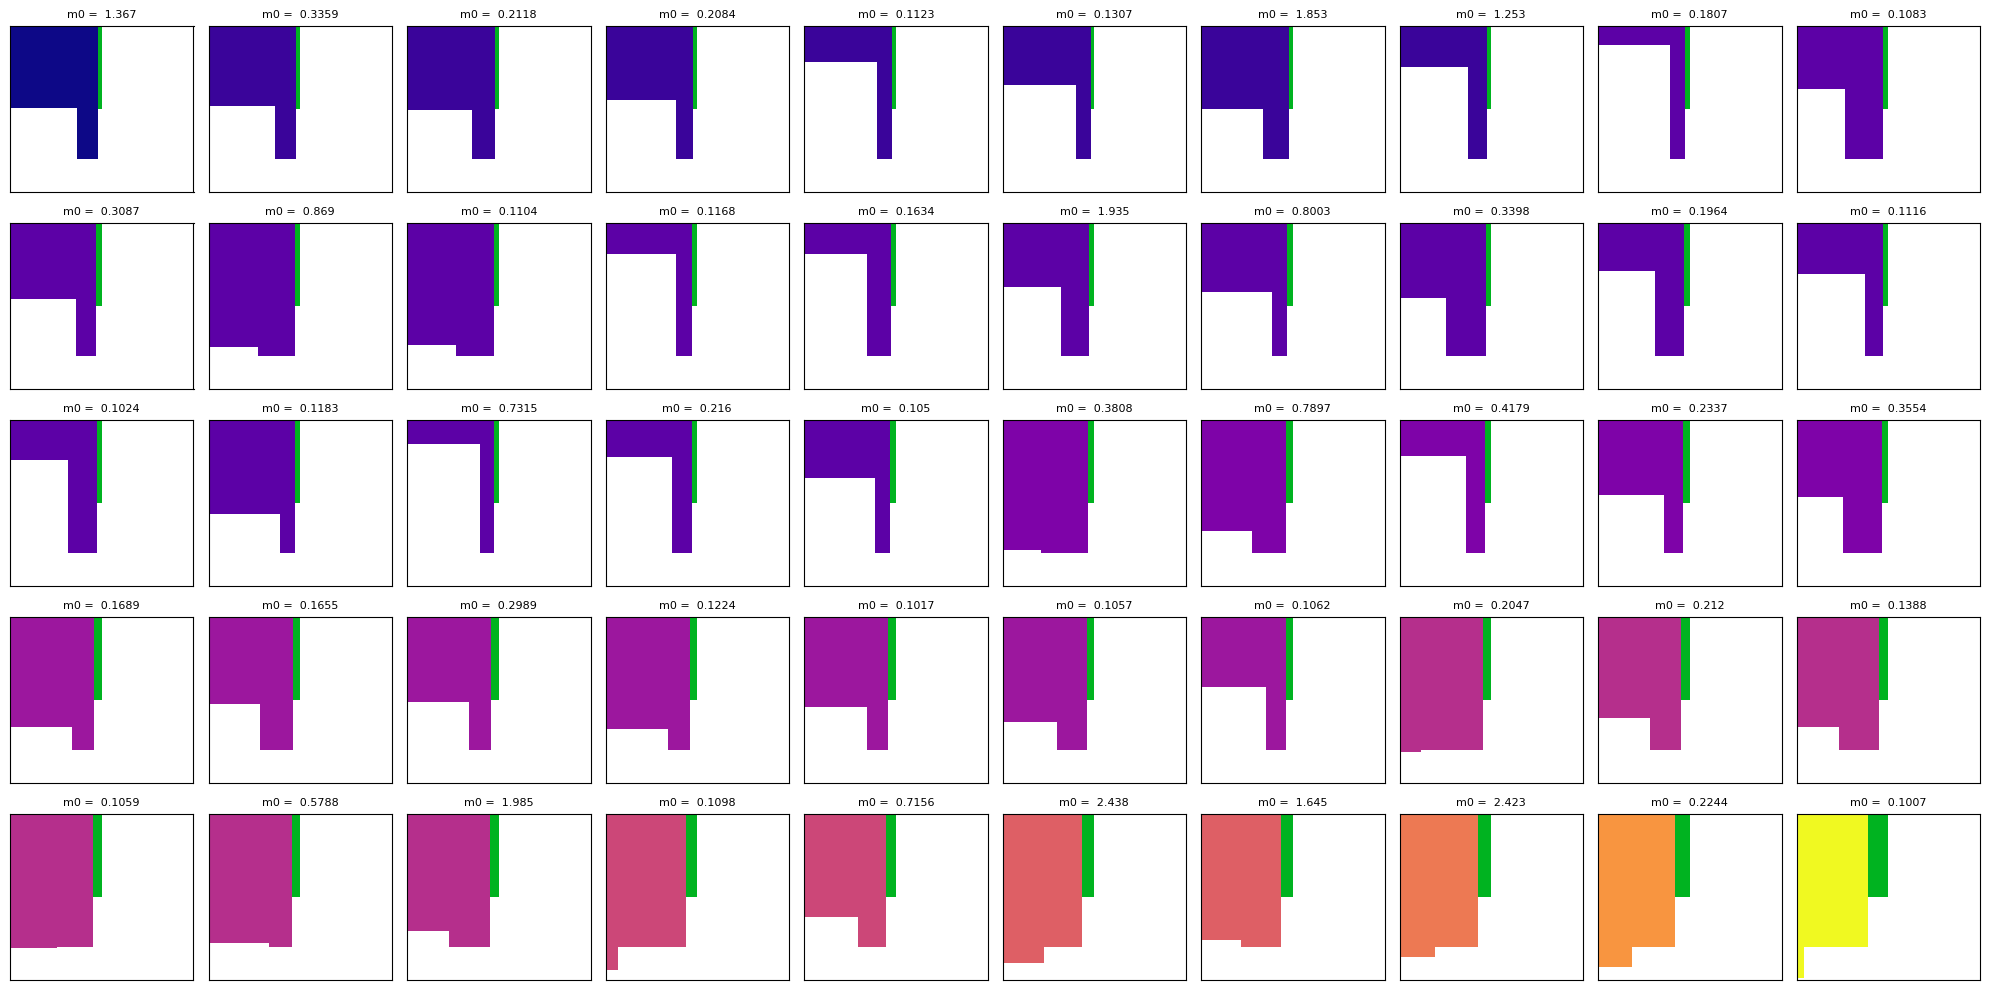

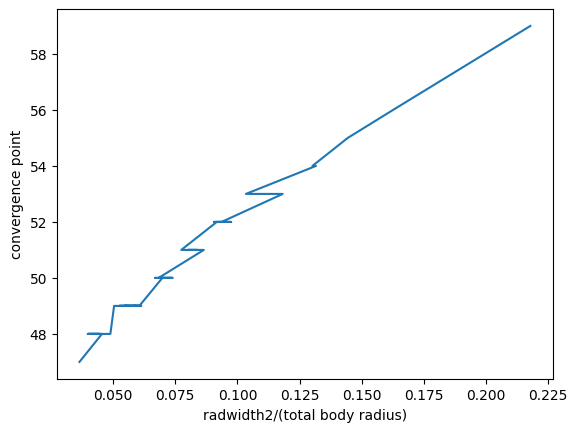

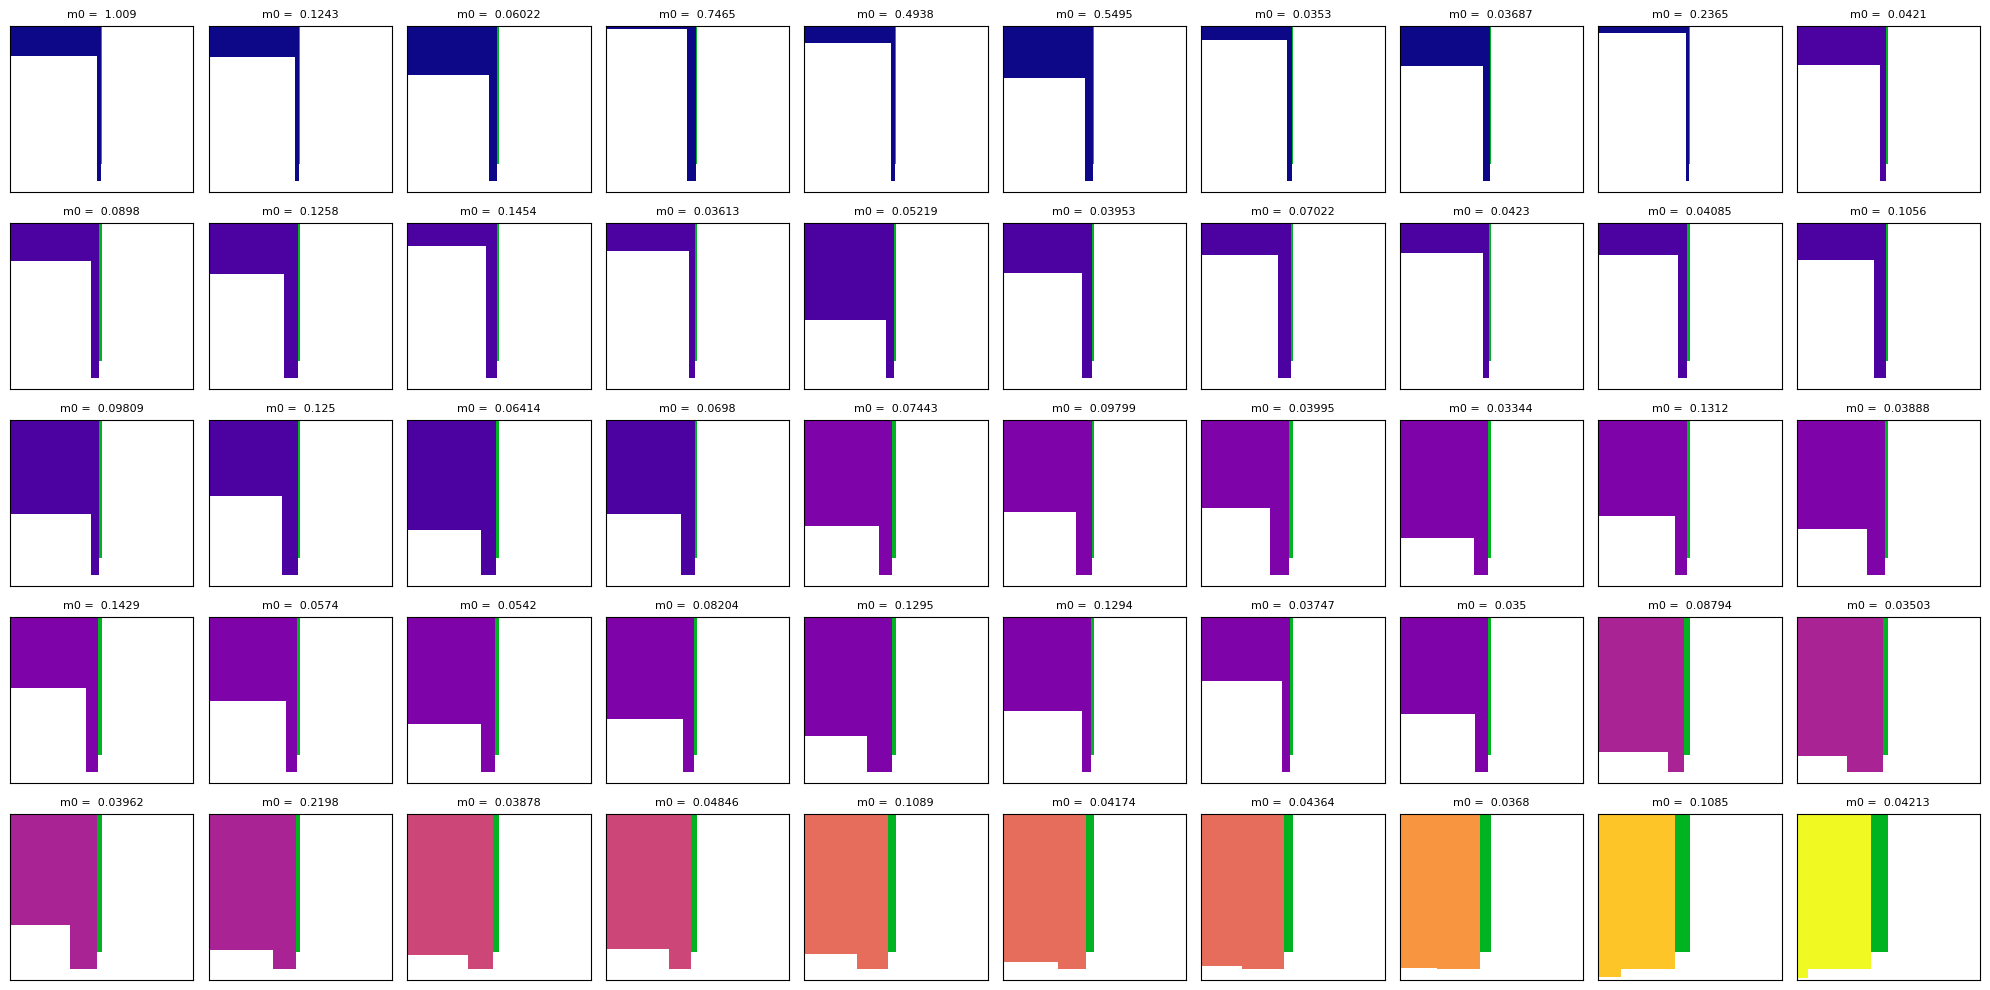

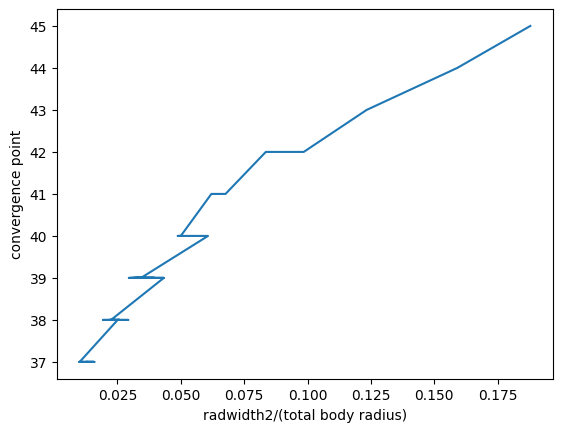

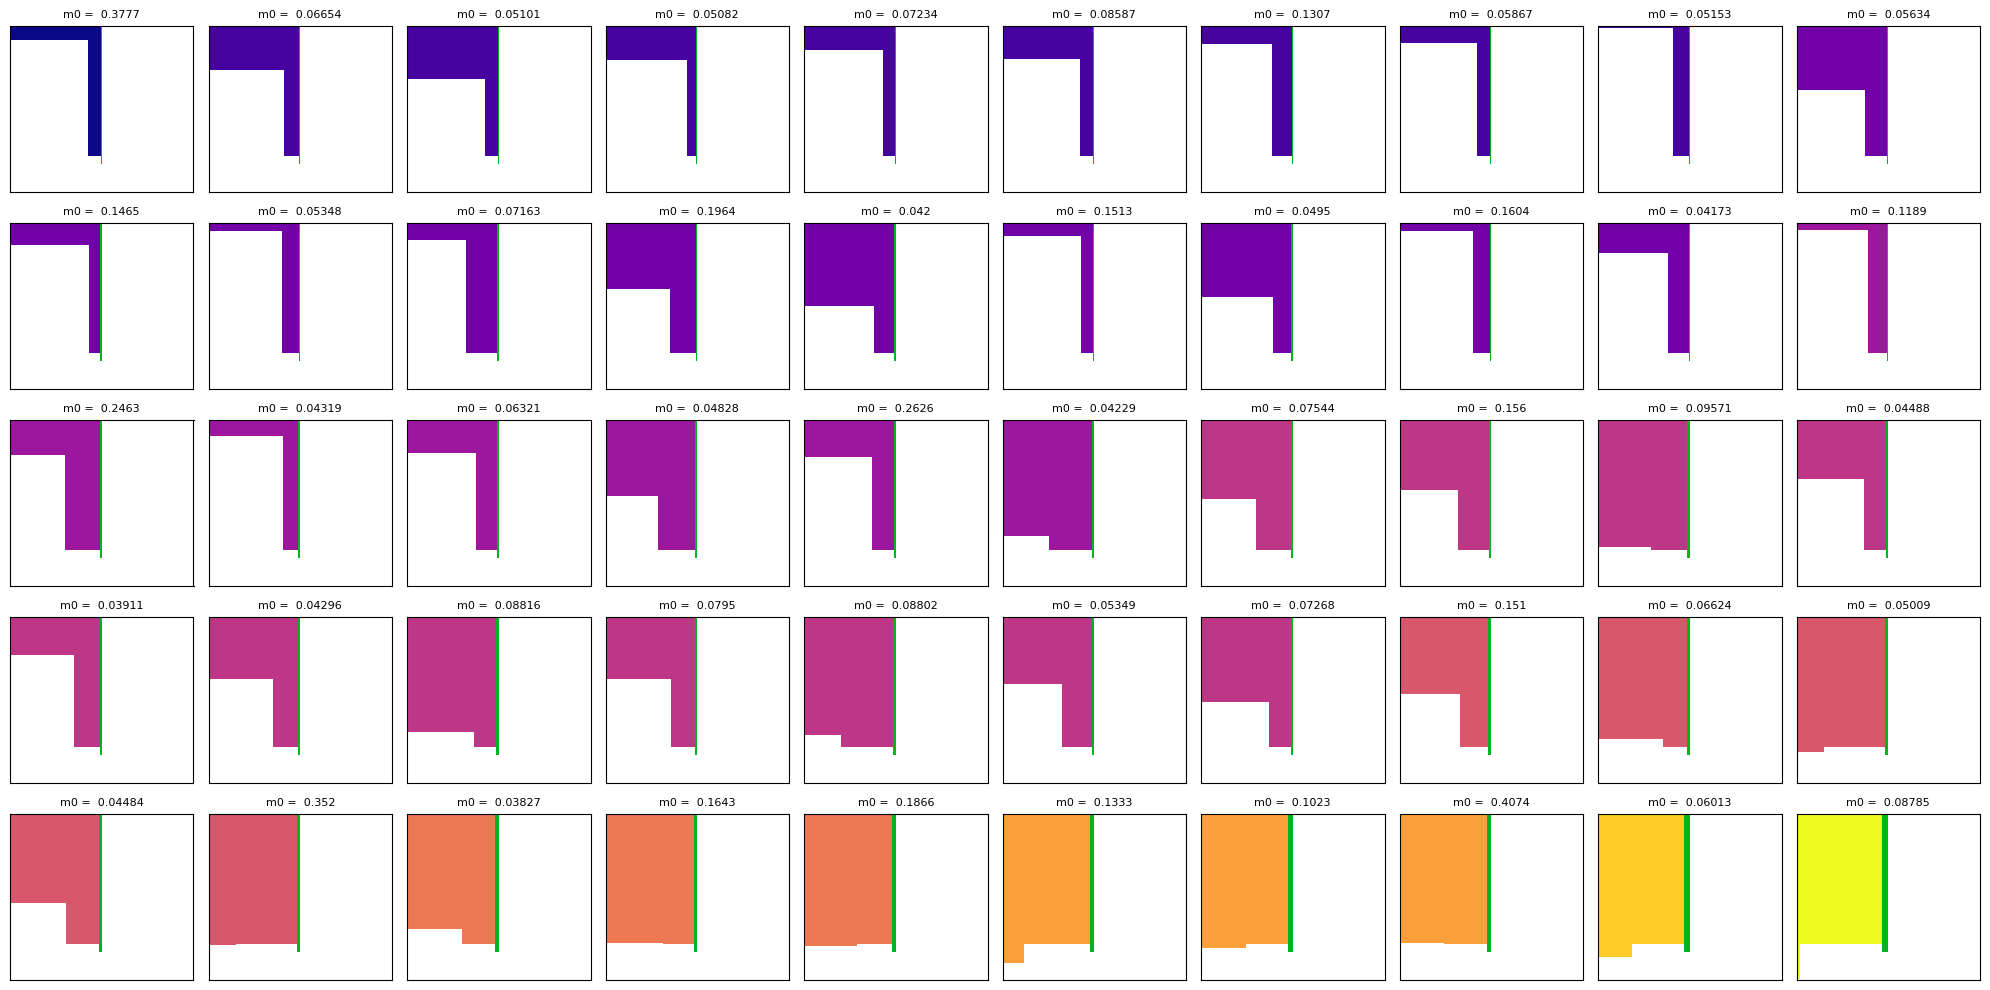

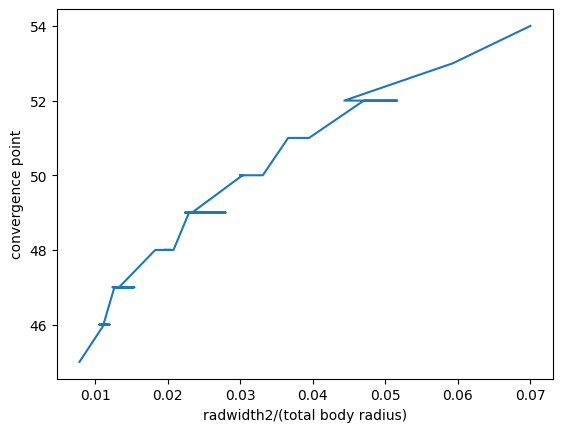

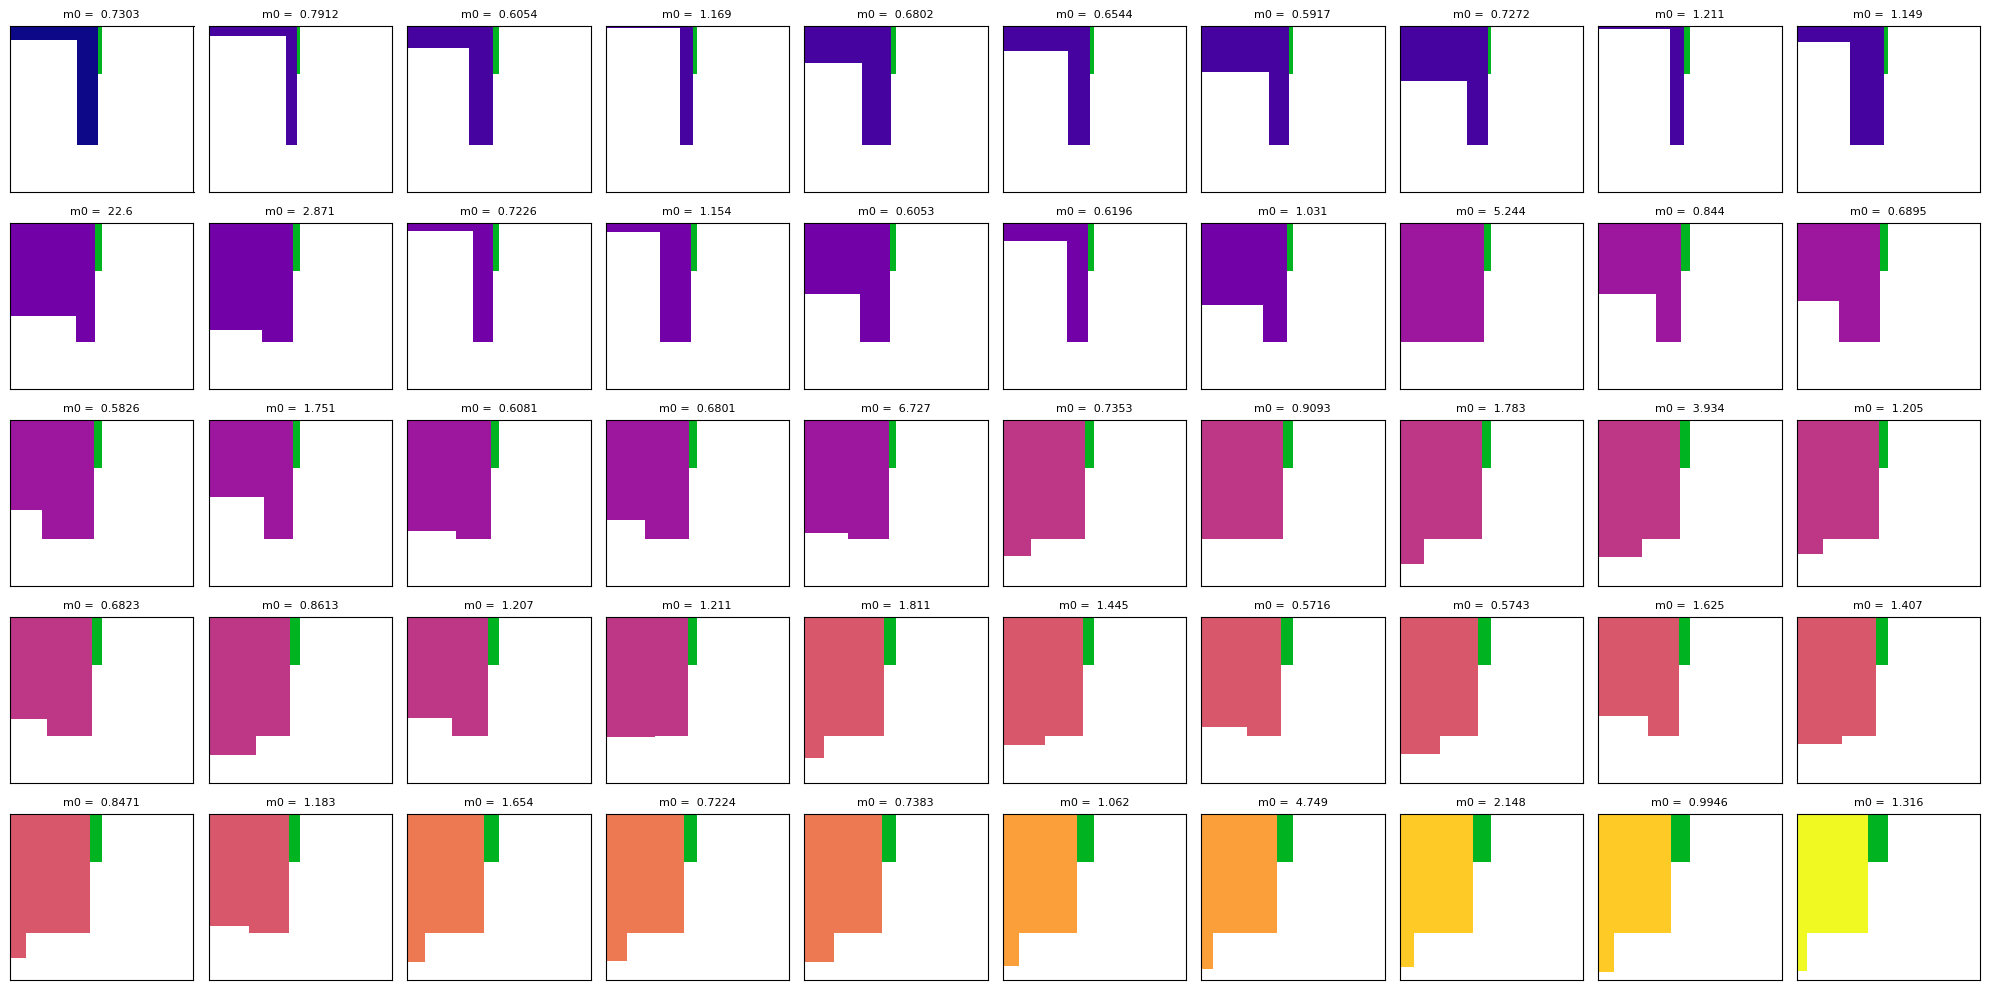

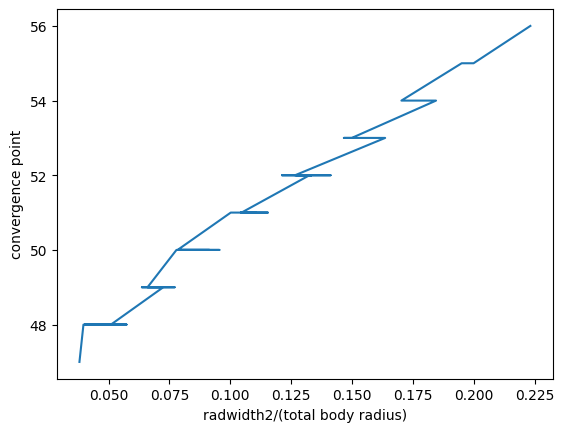

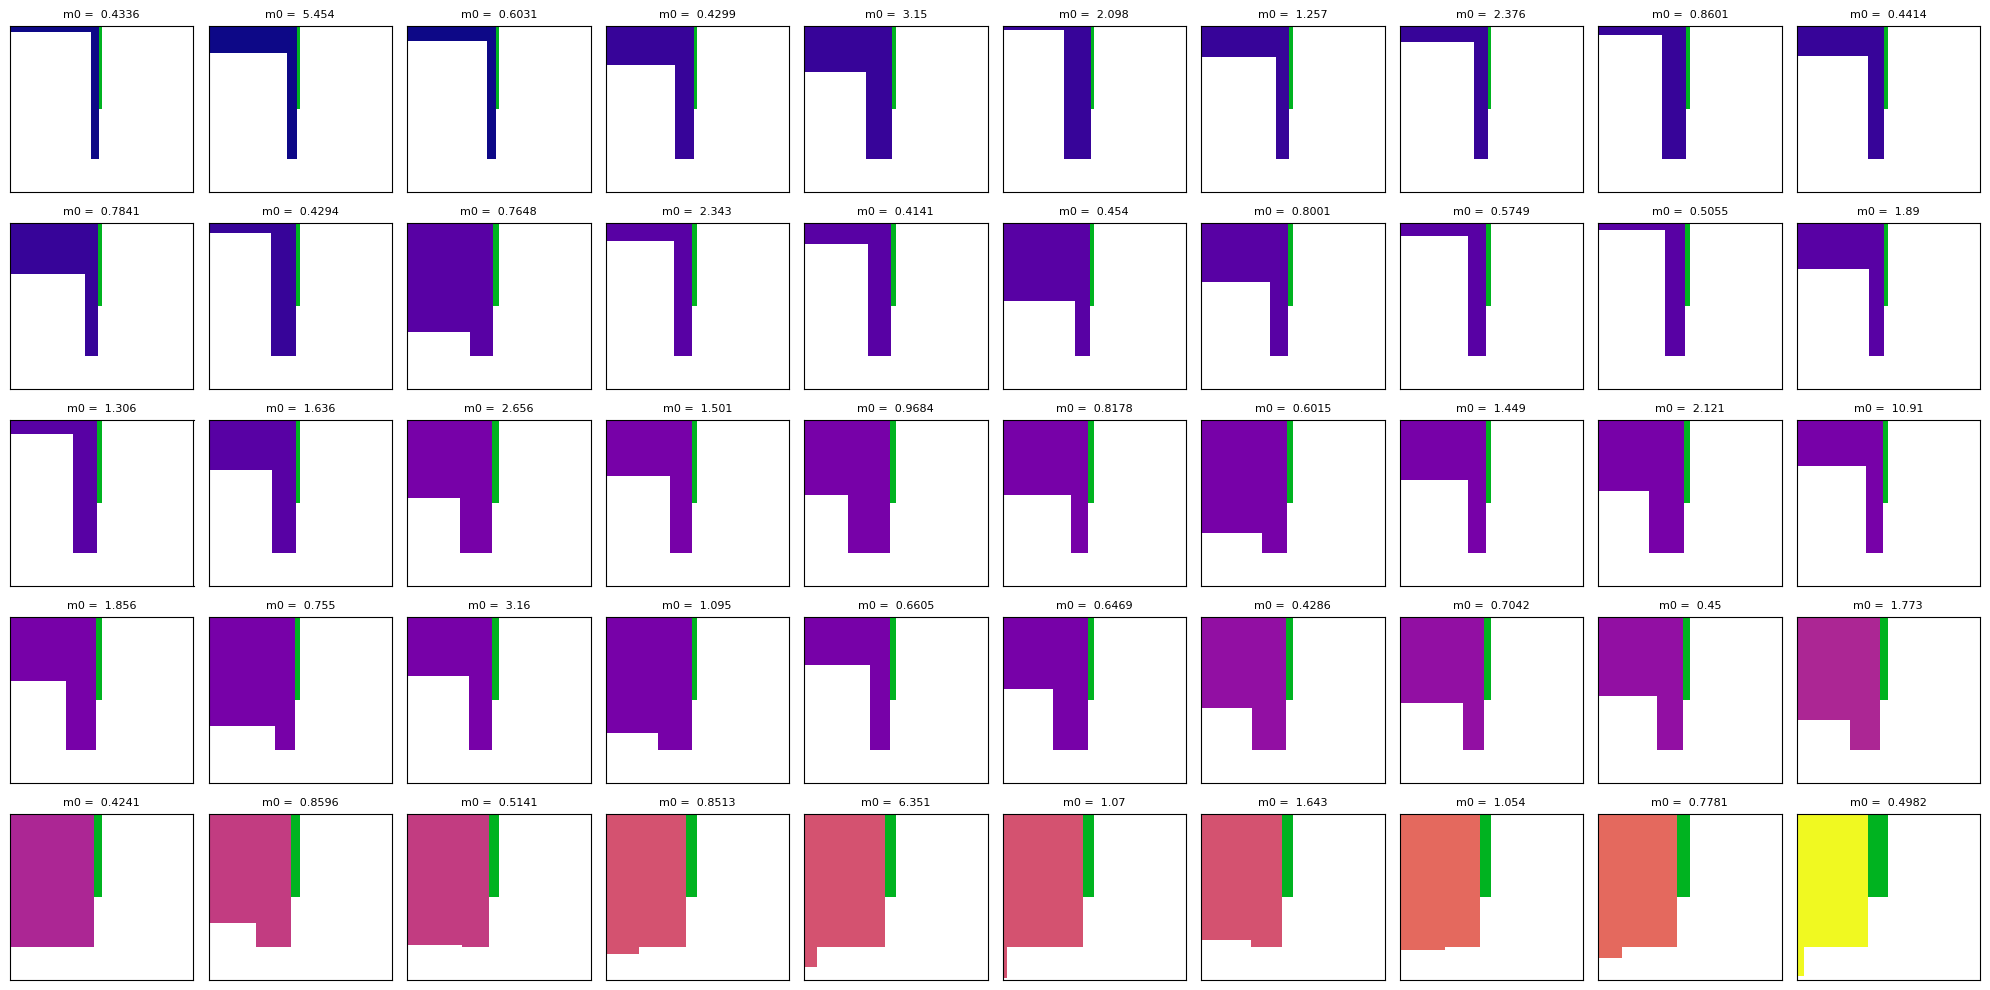

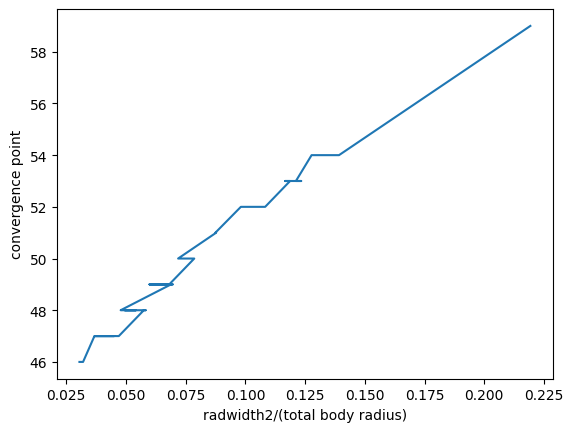

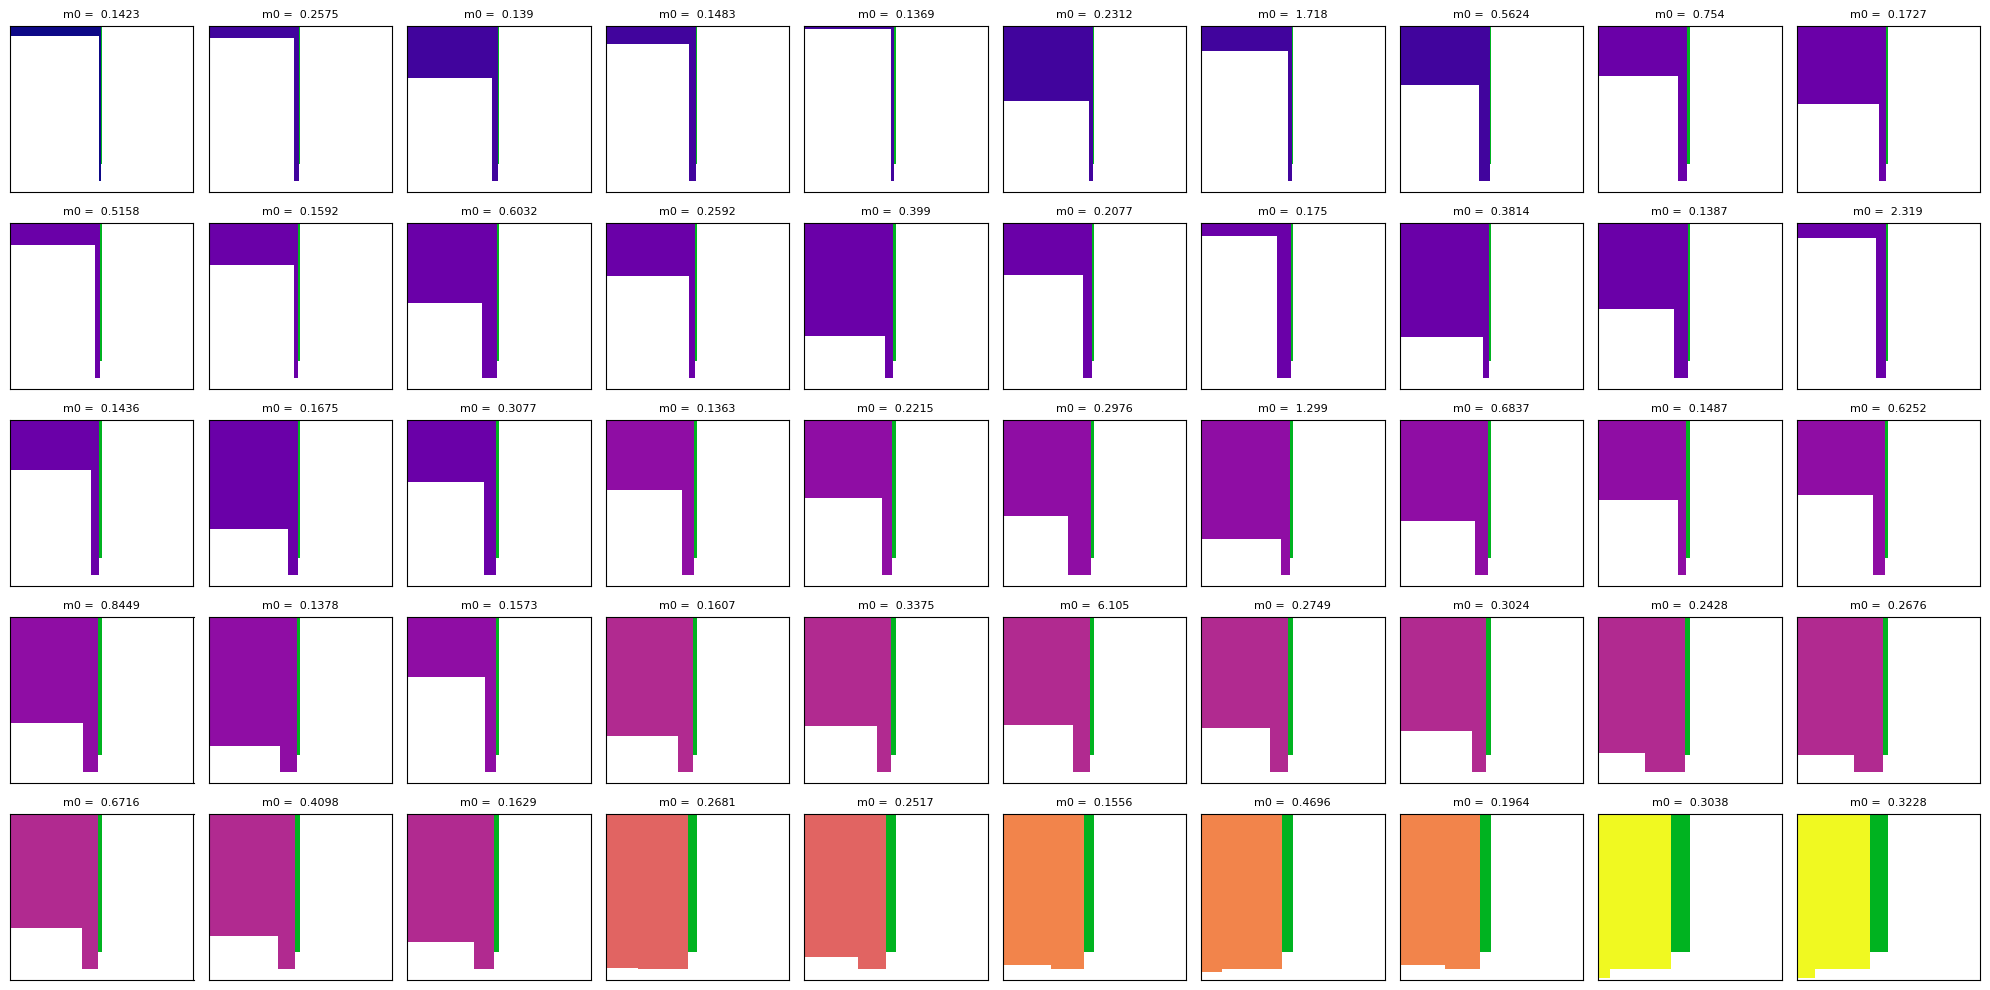

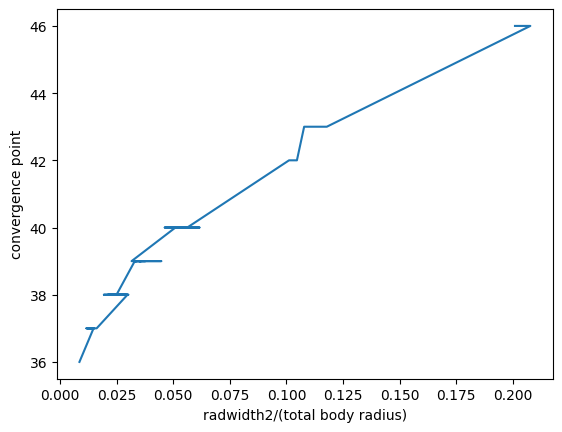

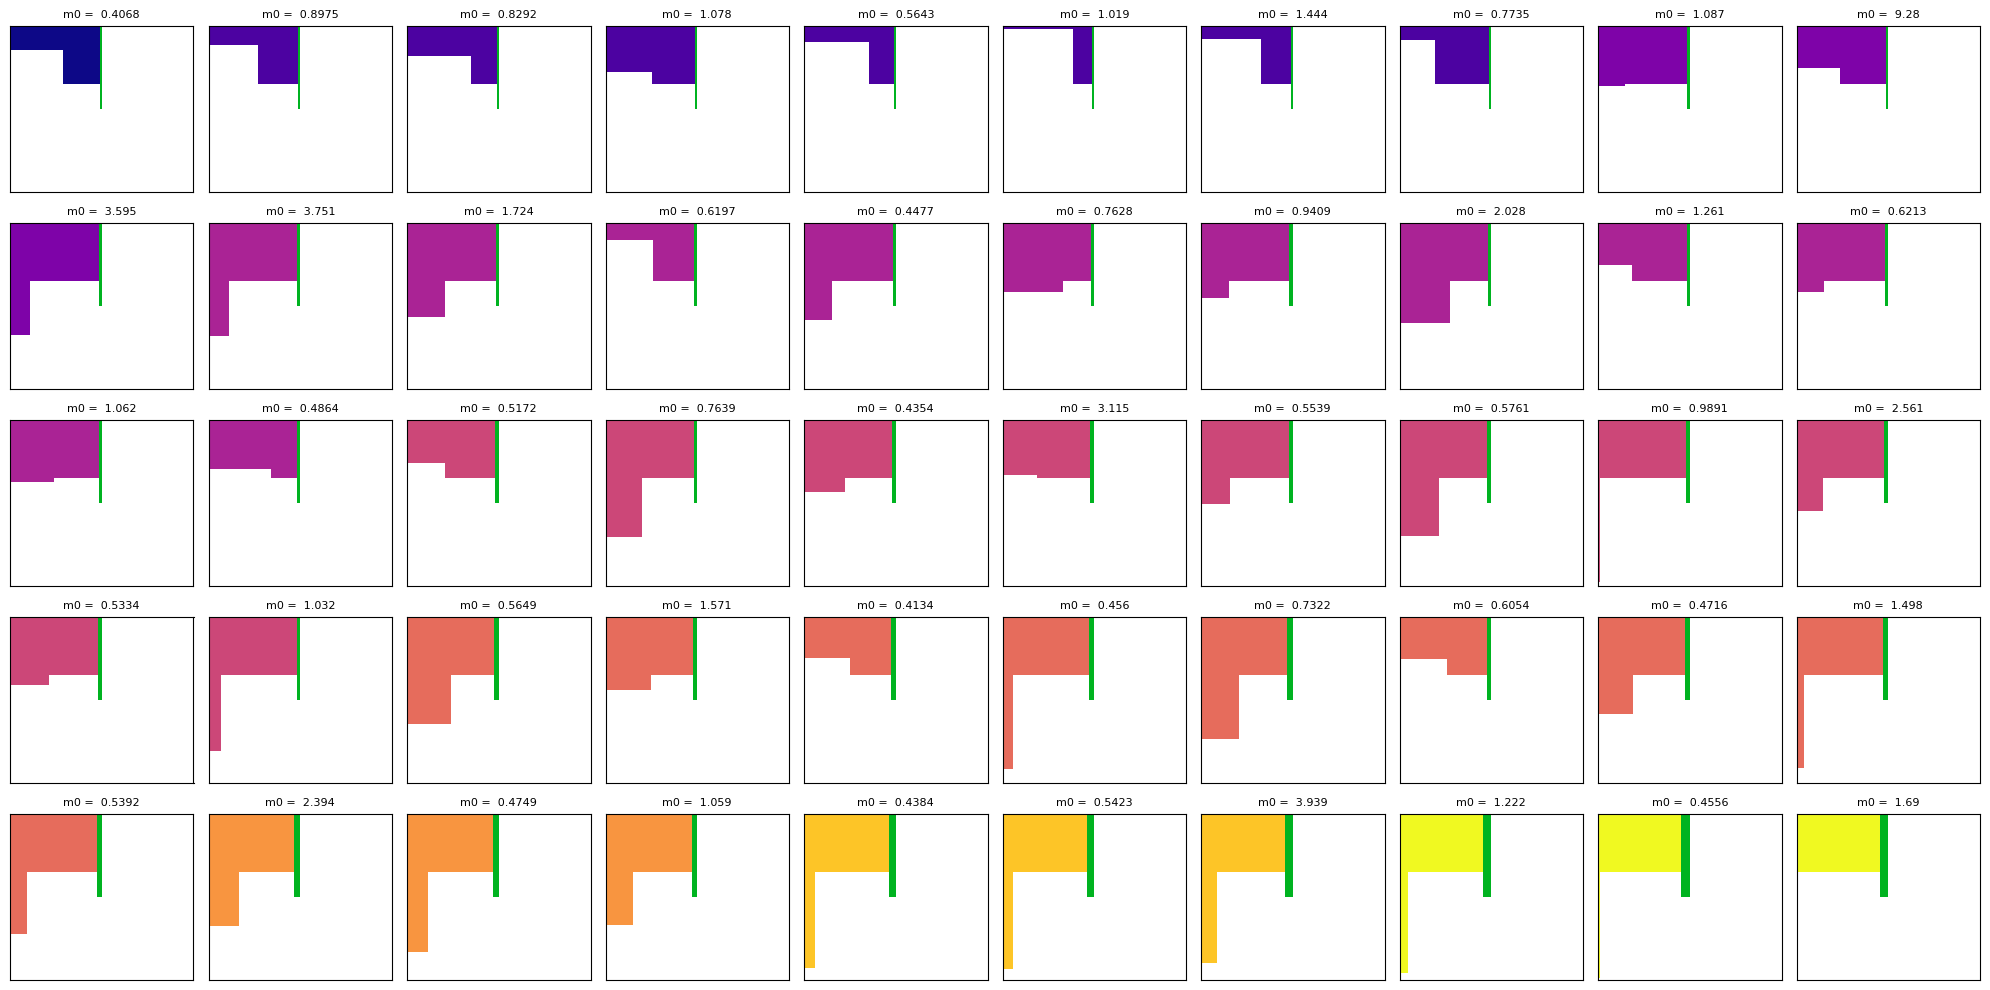

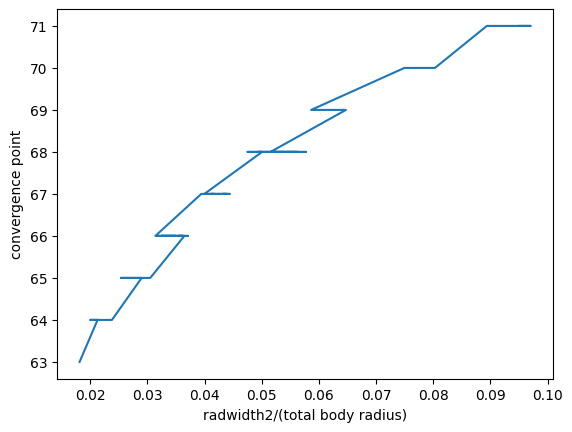

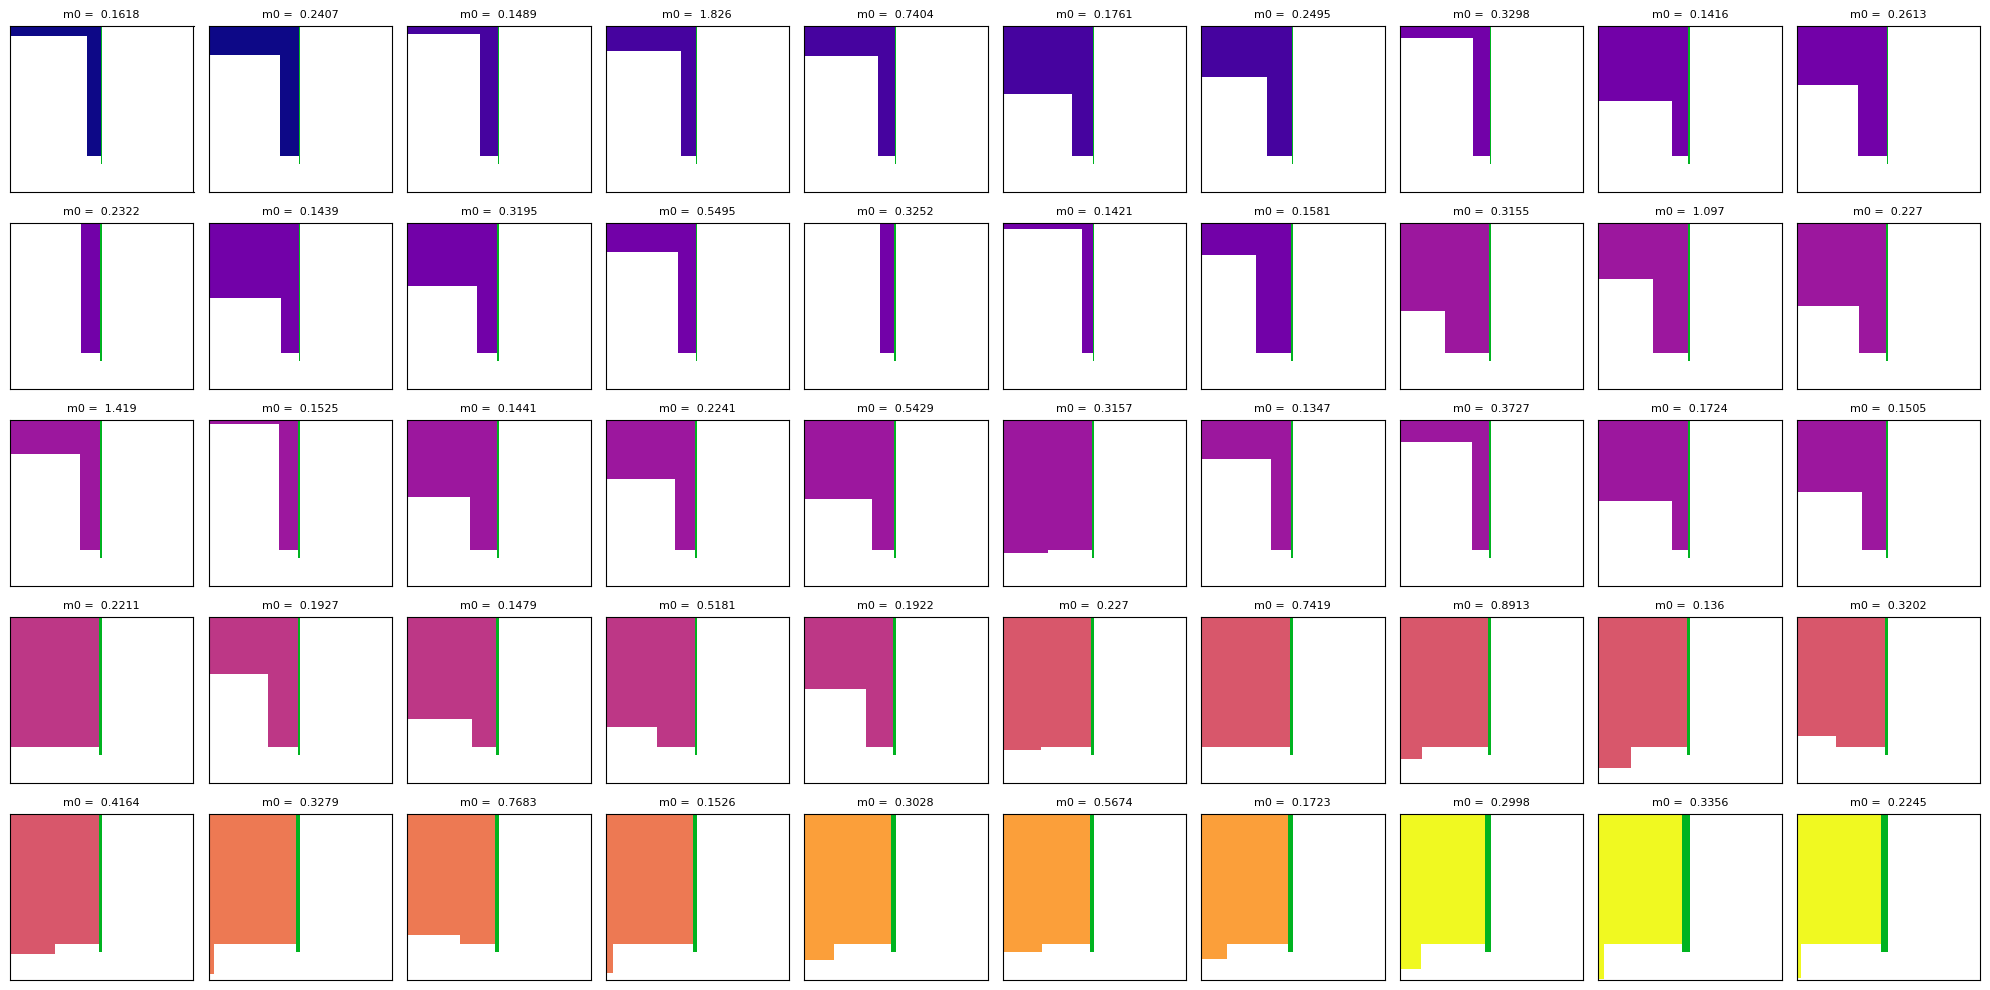

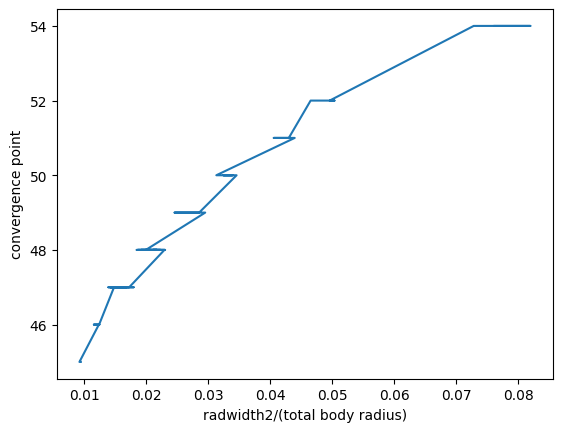

In [24]:
for idx in wide_variation_cases:
  plot_varied_cases(fixed_prob_lsts, idx)

In [12]:
def h_minus_d_over_radwidth(data_dict, region = None):
  if region is None:
    region = data_dict["region"]
  hmd = data_dict["h"] - data_dict["d"][region]
  radwidth = data_dict["a"][0] if region == 0 else (data_dict["a"][region] - data_dict["a"][region - 1])
  return hmd/radwidth

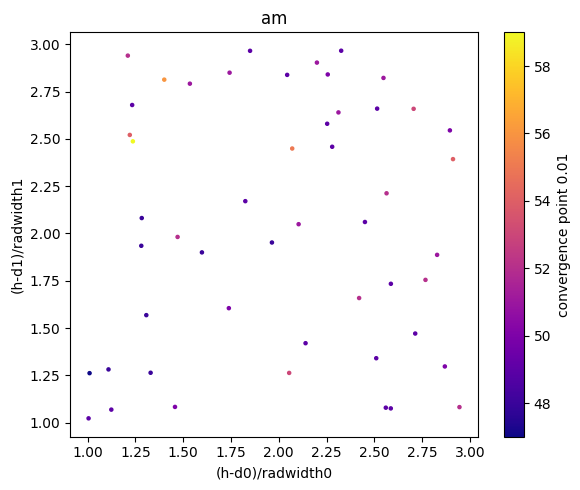

In [13]:
plot_hydros_against_2(subset, "am", 0.01,
                      lambda data_dict, m0 : h_minus_d_over_radwidth(data_dict, region = 0),
                      lambda data_dict, m0 : h_minus_d_over_radwidth(data_dict, region = 1),
                      "(h-d0)/radwidth0", "(h-d1)/radwidth1")

In [ ]:
file2 = "predetermined_1.pkl"

height_ratios = list(np.linspace(0.2, 0.8, 4)) + list(np.linspace(0.9, 1.1, 21)) + list(np.linspace(1.2, 2, 5))
hmdrs = list(np.linspace(2, 20, 10))

big_nmk = 200
nmk_max = 150
NMK = [big_nmk] * 4
heaving = [0, 1, 0]
rho = 1023

# all_prob_dicts = []
# prob = ConvergenceProblemI(h, [1,1,1], [1,2,3], heaving, NMK, m0, rho)
# mk = prob.m_k
# for hmdr in hmdrs:
#   for left_ratio in height_ratios:
#     for right_ratio in height_ratios:
#       d, a = populate_d_a2(h, left_ratio, right_ratio, hmdr)
#       info = {"h" : h,
#               "d" : d,
#               "a" : a,
#               "region" : 1,
#               "m0s" : [m0]}
#       swap_vals(prob, d, a)
#       data_dict = merge_dicts(info, prob.convergence_study_over_m0s(nmk_max, [m0], [mk]))
#       all_prob_dicts.append(data_dict)
#     update_data_file(all_prob_dicts, file2)
#     print("Finished a left ratio.")
#   print("Finished an hmdr.")